#Preprocessing

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from pandas import read_csv
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from scipy.stats import t


# Set numpy print options
np.set_printoptions(suppress=True)

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
df = pd.read_csv('/content/drive/My Drive/P2/filtered_storms_df.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)
df.columns

Index(['Temp_Air', 'Temp_Moist', 'Soil_MC_10', 'Soil_MC_35', 'Soil_MC_65',
       'Soil_MC_91', 'Inflow (mm/s)', 'Overflow(mm/s)', 'Precipitation (mm)',
       'Water_Depth (mm)', 'Recession_Rate (mm/s)', 'SA (mm2)', 'Storm1',
       'Storm2', 'StormID', 'Previous_Dry_Days', 'Accumulated_Rain (mm)',
       'Peak_Rain (mm)', 'Mean_Rain (mm)', 'Peak_Inflow (mm/s)',
       'Min_Inflow (mm/s)', 'Mean_Inflow (mm/s)', 'Min_RR (mm/s)',
       'Mean_RR (mm/s)', 'Max_RR (mm/s)', 'Year', 'Month', 'Day', 'Season_Num',
       'rain_indicator', 'hourly_rain', '30min_rain', '15min_rain'],
      dtype='object')

#Train/test split

In [3]:
# Define input features and target variable
input_columns = [
    'Temp_Air', 'Temp_Moist', 'Soil_MC_10', 'Soil_MC_35', 'Soil_MC_65', 'Soil_MC_91',
    'Inflow (mm/s)', 'Overflow(mm/s)', 'Precipitation (mm)', 'Previous_Dry_Days',
    'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'StormID'
]
target_column = 'Recession_Rate (mm/s)'

# Define test storm IDs
storm_ids = {12, 14, 40, 20, 57, 52, 61, 65, 70, 85, 95, 163, 158, 171, 115,
             200, 231, 221, 237, 244, 273, 277, 261, 296, 299, 304, 305, 325,
             326, 214, 205}

# Split into train and test sets
test_df, train_df = df[df['StormID'].isin(storm_ids)], df[~df['StormID'].isin(storm_ids)]

# Extract input and target variables
X_train, y_train = train_df[input_columns], train_df[target_column]
X_test, y_test = test_df[input_columns], test_df[target_column]

# Scale features
scaler = StandardScaler()
X_train_scaled, X_test_scaled = scaler.fit_transform(X_train), scaler.transform(X_test)

#Model

In [4]:
# RF model
model = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_leaf=4, min_samples_split=2, random_state=42)  # You can adjust the number of estimators as needed
# Fit
model.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=4, random_state=42)

#Predict

In [5]:
# Function to evaluate model performance
def evaluate_model(y_true, y_pred, dataset_name="Train"):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    evs = explained_variance_score(y_true, y_pred)

    print(f"\n📊 {dataset_name} Performance Metrics:")
    print(f" - Mean Squared Error (MSE): {mse:.4f}")
    print(f" - Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f" - Mean Absolute Error (MAE): {mae:.4f}")
    print(f" - R-squared (R²): {r2:.4f}")
    print(f" - Explained Variance Score (EVS): {evs:.4f}")

# Make predictions
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

# Evaluate performance
evaluate_model(y_train, y_pred_train, "Train")
evaluate_model(y_test, y_pred_test, "Test")


📊 Train Performance Metrics:
 - Mean Squared Error (MSE): 0.0000
 - Root Mean Squared Error (RMSE): 0.0059
 - Mean Absolute Error (MAE): 0.0032
 - R-squared (R²): 0.7953
 - Explained Variance Score (EVS): 0.7953

📊 Test Performance Metrics:
 - Mean Squared Error (MSE): 0.0001
 - Root Mean Squared Error (RMSE): 0.0091
 - Mean Absolute Error (MAE): 0.0038
 - R-squared (R²): 0.6114
 - Explained Variance Score (EVS): 0.6117


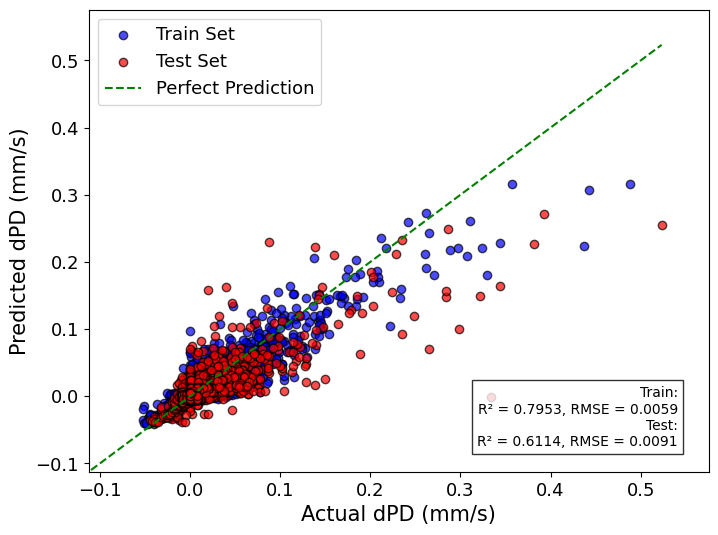

In [ ]:
# Compute regression metrics
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

# Perform linear regression analysis
slope, intercept, r_value, p_value, std_err = stats.linregress(y_train, y_pred_train)

# Create scatter plots for Train and Test sets
plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_pred_train, c='blue', edgecolors='k', alpha=0.7, label='Train Set')
plt.scatter(y_test, y_pred_test, c='red', edgecolors='k', alpha=0.7, label='Test Set')

# Add a diagonal line for perfect predictions
min_val, max_val = min(min(y_train), min(y_test)), max(max(y_train), max(y_test))
plt.plot([min_val, max_val], [min_val, max_val], 'g--', label='Perfect Prediction')

# Customize plot labels and styling
plt.xlabel("Actual dPD (mm/s)", fontsize=15)
plt.ylabel("Predicted dPD (mm/s)", fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

# Ensure RMSE & R² values are defined before using them in text
text_msg = (
    f"Train:\nR² = {r2_train:.4f}, RMSE = {rmse_train:.4f}\n"
    f"Test:\nR² = {r2_test:.4f}, RMSE = {rmse_test:.4f}"
)
plt.text(0.95, 0.05, text_msg, ha='right', va='bottom', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8))

plt.xlim([min_val * 0.3, max_val * 1.1])
plt.ylim([min_val * 0.3, max_val * 1.1])
plt.legend(fontsize=13)
plt.show()

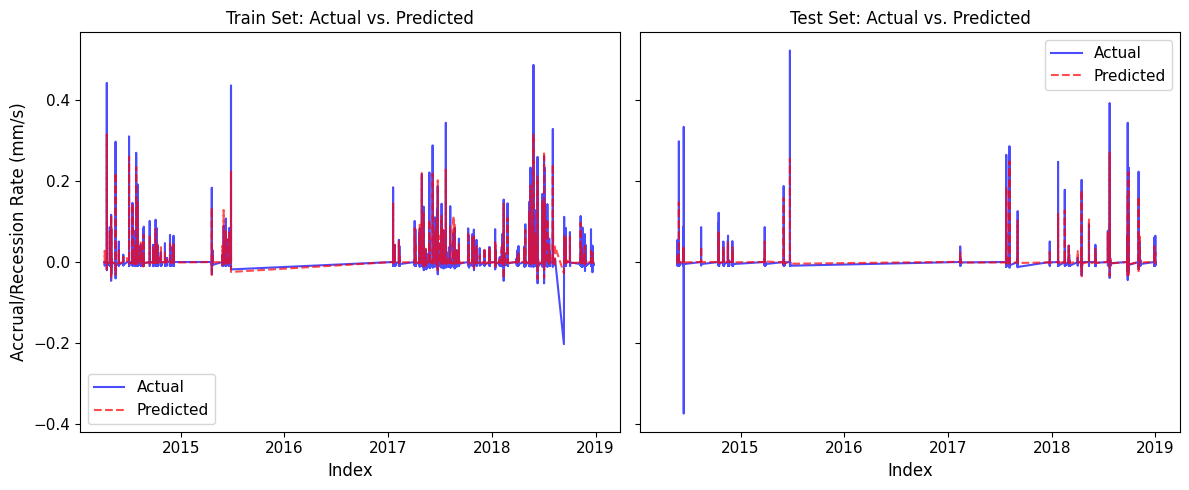

In [ ]:
# Train and test time series
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), sharex=True, sharey=True)

# Train Set Plot
axes[0].plot(y_train.index, y_train, label='Actual', color='blue', alpha=0.7)
axes[0].plot(y_train.index, y_pred_train, label='Predicted', color='red', linestyle='dashed', alpha=0.7)
axes[0].set_title("Train Set: Actual vs. Predicted", fontsize=12)
axes[0].set_xlabel("Index", fontsize=12)
axes[0].set_ylabel("Accrual/Recession Rate (mm/s)", fontsize=12)
axes[0].legend(fontsize=11)
axes[0].tick_params(axis='both', which='major', labelsize=11)

# Test Set Plot
axes[1].plot(y_test.index, y_test, label='Actual', color='blue', alpha=0.7)
axes[1].plot(y_test.index, y_pred_test, label='Predicted', color='red', linestyle='dashed', alpha=0.7)
axes[1].set_title("Test Set: Actual vs. Predicted", fontsize=12)
axes[1].set_xlabel("Index", fontsize=12)
axes[1].legend(fontsize=11)
axes[1].tick_params(axis='both', which='major', labelsize=11)

plt.tight_layout()
plt.show()

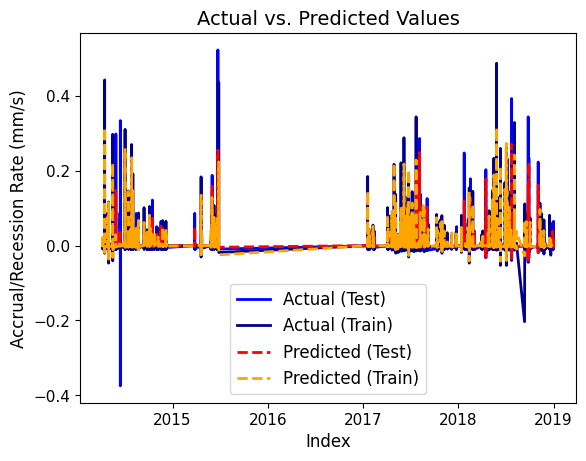

In [ ]:
# Train and test time series together

fig, ax = plt.subplots()

# Plot the actual values in blue
ax.plot(y_test.index, y_test, label='Actual (Test)', color='blue', linewidth=2)
ax.plot(y_train.index, y_train, label='Actual (Train)', color='darkblue', linewidth=2)

# Plot the predicted values for test and train in different colors
ax.plot(y_test.index, y_pred_test, label='Predicted (Test)', color='red', linestyle='dashed', linewidth=2)
ax.plot(y_train.index, y_pred_train, label='Predicted (Train)', color='orange', linestyle='dashed', linewidth=2)

# Add labels and legend with fontsize=12
ax.set_xlabel("Index", fontsize=12)
ax.set_ylabel("Accrual/Recession Rate (mm/s)", fontsize=12)
ax.set_title("Actual vs. Predicted Values", fontsize=14)
ax.legend(fontsize=12)

# Set font size for axis ticks
ax.tick_params(axis='both', which='major', labelsize=11)

# Show the combined plot
plt.show()

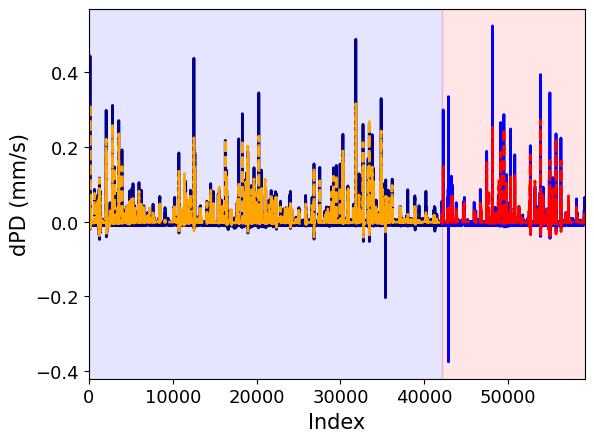

In [ ]:
fig, ax = plt.subplots()

# Create fresh, separate indices for y_train and y_test
train_index = np.arange(len(y_train))
test_index = np.arange(len(y_test)) + len(y_train)  # Ensures test index starts after the train index ends

# Plot the actual and predicted values for training data in dark blue and orange
ax.plot(train_index, y_train, label='Actual (Train)', color='darkblue', linewidth=2)
ax.plot(train_index, y_pred_train, label='Predicted (Train)', color='orange', linestyle='dashed', linewidth=2)

# Plot the actual and predicted values for test data in blue and red, using the new test index
ax.plot(test_index, y_test, label='Actual (Test)', color='blue', linewidth=2)
ax.plot(test_index, y_pred_test, label='Predicted (Test)', color='red', linestyle='dashed', linewidth=2)

# Add a light shade in the background for train and test data
ax.axvspan(train_index.min(), train_index.max(), color='blue', alpha=0.1)
ax.axvspan(test_index.min(), test_index.max(), color='red', alpha=0.1)

# Update font sizes to match the first snippet
ax.set_xlabel("Index", fontsize=15)
ax.set_ylabel("dPD (mm/s)", fontsize=15)
# ax.set_title("Actual vs. Predicted Values (Train and Test Side by Side)", fontsize=14) # If title is needed
# ax.legend(fontsize=15)

# Set font size for axis ticks
ax.tick_params(axis='both', which='major', labelsize=13)

# Optionally, set x-axis limits to better frame the plot
ax.set_xlim([0, max(test_index) + 1])

# Show the combined plot
plt.show()

# Residual Analysis

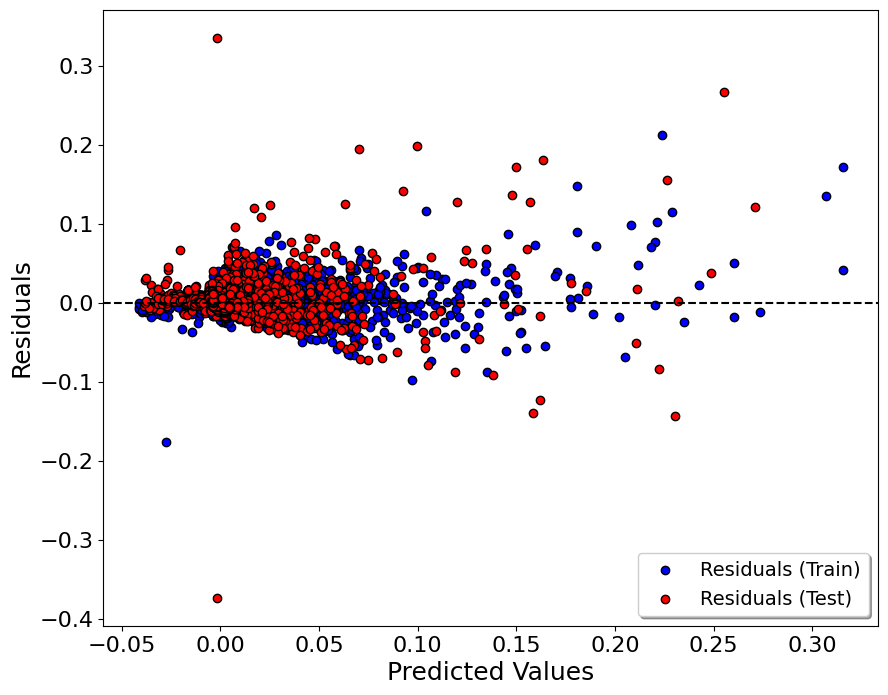

In [ ]:
# Calculate residuals for both train and test sets
residuals_train = y_train - y_pred_train
residuals_test = y_test - y_pred_test

# Create a combined scatter plot of residuals vs predicted values for both datasets
plt.figure(figsize=(10, 8))  # Adjusted figure size for better visibility

# Training data in blue
plt.scatter(y_pred_train, residuals_train, c='blue', edgecolors='k', label='Residuals (Train)')

# Testing data in red
plt.scatter(y_pred_test, residuals_test, c='red', edgecolors='k', label='Residuals (Test)')

# Configure labels with increased font sizes
plt.xlabel("Predicted Values", fontsize=18)  # Matching the increased font size
plt.ylabel("Residuals", fontsize=18)  # Matching the increased font size

# Add a horizontal line at y=0 to represent perfect predictions
plt.axhline(y=0, color='black', linestyle='--')

# Add a combined legend for all plot elements on the bottom right with increased font size
plt.legend(loc='lower right', fontsize=14, frameon=True, shadow=True)  # Matching the increased font size for legend

# Display the plot
plt.show()

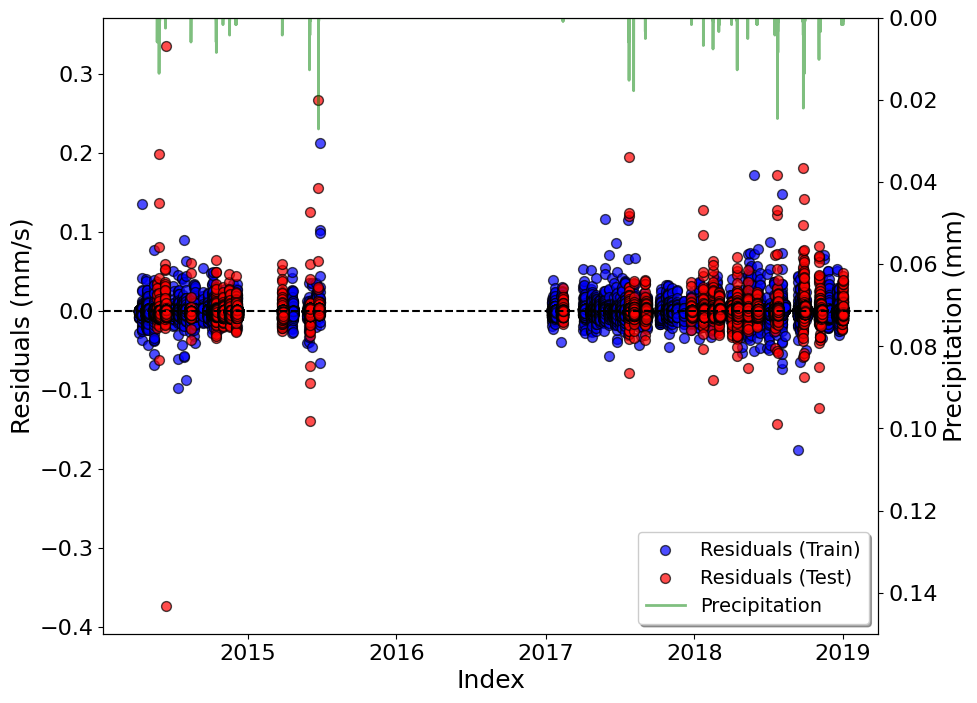

In [ ]:
# Increase global font size for better visibility
plt.rcParams.update({'font.size': 16})

# Create a figure and axis for the scatter plot
fig, ax1 = plt.subplots(figsize=(10, 8))

# Plot residuals for training data (blue)
train_scatter = ax1.scatter(
    y_train.index, y_train - y_pred_train, c='blue', edgecolors='k', s=50, alpha=0.7, label='Residuals (Train)'
)

# Plot residuals for testing data (red)
test_scatter = ax1.scatter(
    y_test.index, y_test - y_pred_test, c='red', edgecolors='k', s=50, alpha=0.7, label='Residuals (Test)'
)

# Configure primary y-axis
ax1.axhline(y=0, color='black', linestyle='--')  # Add a reference line at y=0
ax1.set_xlabel("Index", fontsize=18)
ax1.set_ylabel("Residuals (mm/s)", fontsize=18)

# Create a secondary y-axis for 'Precipitation'
ax2 = ax1.twinx()
ax2.invert_yaxis()  # Invert the y-axis for precipitation
ax2.set_ylim(0.15, 0)

# Plot 'Precipitation' on the secondary y-axis (using correct index)
precipitation_line, = ax2.plot(
    y_test.index, df.loc[y_test.index, 'Precipitation (mm)'], color='green', alpha=0.5, linewidth=2, label='Precipitation'
)

ax2.set_ylabel("Precipitation (mm)", color='black', fontsize=18)  # Set y-axis label for precipitation

# Create a combined legend for residuals & precipitation
handles = [train_scatter, test_scatter, precipitation_line]
labels = ["Residuals (Train)", "Residuals (Test)", "Precipitation"]
ax1.legend(handles, labels, loc="lower right", fontsize=14, frameon=True, shadow=True)

plt.show()

In [ ]:
residuals = y_test - y_pred_test

# Compute Q1, Q3, and IQR
Q1, Q3 = np.percentile(residuals, [25, 75])
IQR = Q3 - Q1

# Determine outlier bounds
lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

# Identify outliers and their count
outliers = np.where((residuals < lower_bound) | (residuals > upper_bound))[0]
num_outliers = len(outliers)

# Compute percentage of outliers
percentage_outliers = (num_outliers / len(residuals)) * 100

print(f"Number of outliers: {num_outliers}")
print(f"Lower bound: {lower_bound:.4f}, Upper bound: {upper_bound:.4f}")
print(f"Percentage of outliers: {percentage_outliers:.2f}%")

Number of outliers: 1208
Lower bound: -0.0084, Upper bound: 0.0085
Percentage of outliers: 7.07%


# Specific Storm

In [ ]:
# Filter data for the specific storm event "212"
specific_event_df = df[df['StormID'] == 212]

# Extract input features and target variable
X_specific = specific_event_df[input_columns]
y_specific = specific_event_df[target_column]

# Standardize input features
X_specific_scaled = scaler.transform(X_specific)

# Make predictions
y_pred_specific = model.predict(X_specific_scaled)

# Compute model evaluation metrics
mse = mean_squared_error(y_specific, y_pred_specific)
rmse = np.sqrt(mse)
r2 = r2_score(y_specific, y_pred_specific)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Mean Squared Error (MSE): 0.0000
Root Mean Squared Error (RMSE): 0.0046
R-squared (R²): 0.8521


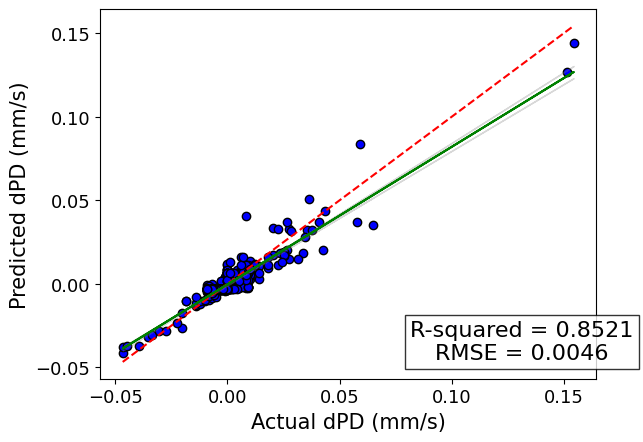

In [ ]:
# Calculate the linear regression model
slope, intercept, r_value, p_value, std_err = stats.linregress(y_specific_event, y_pred_specific_event)

# Create a scatter plot
plt.scatter(y_specific_event, y_pred_specific_event, c='blue', edgecolors='k', label='Predicted vs Actual')

# Add a diagonal line to represent a perfect prediction
plt.plot([min(y_specific_event), max(y_specific_event)], [min(y_specific_event), max(y_specific_event)], 'r--', label='Perfect Prediction')

# Plot the regression line
plt.plot(np.array(y_specific_event), intercept + slope * np.array(y_specific_event), color='green', label='Regression Line')

# Calculate the confidence interval for the regression line
x = np.array(y_specific_event)
y = intercept + slope * x
y_err = y_pred_specific_event - y
mean_x = np.mean(x)
n = len(x)
dof = n - 2
t = stats.t.ppf(0.975, dof)
s_err = np.sum(np.power(y_err, 2))
conf = t * np.sqrt((s_err / (n - 2)) * (1.0 / n + (np.power((x - mean_x), 2) / ((np.sum(np.power(x, 2))) - n * (np.power(mean_x, 2))))))

# Plot the confidence interval
plt.fill_between(x, y - conf, y + conf, color='gray', alpha=0.3, label='Confidence Interval')

# Update font sizes to match the first snippet
plt.xlabel("Actual dPD (mm/s)", fontsize=15)
plt.ylabel("Predicted dPD (mm/s)", fontsize=15)
# plt.title("Storm Event", fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.legend(fontsize=15) # Uncomment if legend is needed

# Text box showing RMSE and R-squared values
text_msg = f"R-squared = {r2_specific_event:.4f}\nRMSE = {rmse:.4f}"
plt.text(0.85, 0.1, text_msg, ha='center', va='center', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8))

plt.show()

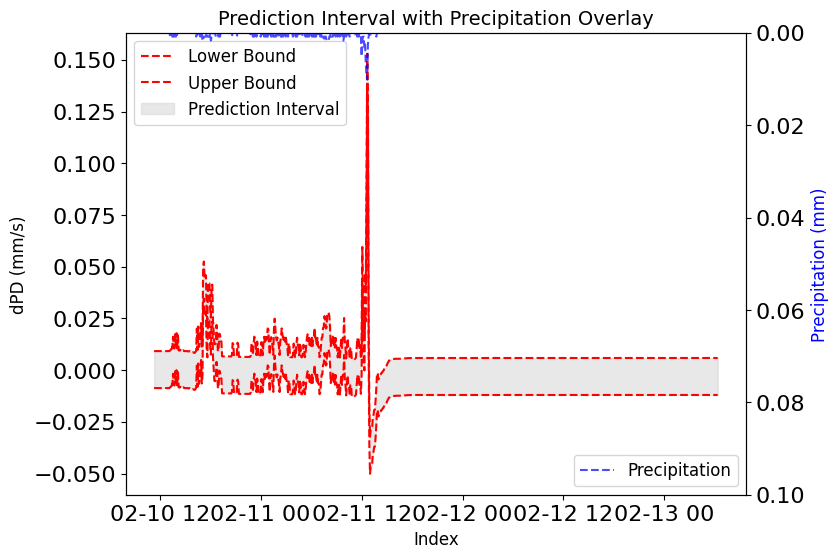

In [ ]:
# Compute residuals
residuals = y_specific_event - y_pred_specific_event

# Compute standard error of residuals
residual_std = np.std(residuals)

# Confidence level (95%) and critical value for two-tailed test
confidence_level = 0.95
t_critical = t.ppf(1 - (1 - confidence_level) / 2, df=len(residuals) - 2)

# Compute margin of error and prediction interval bounds
margin_of_error = t_critical * residual_std
lower_bound = y_pred_specific_event - margin_of_error
upper_bound = y_pred_specific_event + margin_of_error

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot prediction interval
ax.plot(y_specific_event.index, lower_bound, 'r--', label='Lower Bound')
ax.plot(y_specific_event.index, upper_bound, 'r--', label='Upper Bound')
ax.fill_between(y_specific_event.index, lower_bound, upper_bound, color='lightgray', alpha=0.5, label='Prediction Interval')

# Configure main axis
ax.set_xlabel("Index", fontsize=12)
ax.set_ylabel("dPD (mm/s)", fontsize=12)
ax.set_title("Prediction Interval with Precipitation Overlay", fontsize=14)
ax.legend(loc='upper left', fontsize=12)  # Move legend to upper left

# Create secondary y-axis for precipitation
ax2 = ax.twinx()
ax2.invert_yaxis()  # Invert y-axis for precipitation
ax2.set_ylim(0.1, 0)  # Set limits for precipitation y-axis

# Plot 'Precipitation' on the secondary y-axis
precipitation_event = df.loc[y_specific_event.index, 'Precipitation (mm)']
ax2.plot(precipitation_event.index, precipitation_event, color='blue', alpha=0.7, linestyle='--', label='Precipitation')

ax2.set_ylabel("Precipitation (mm)", fontsize=12, color='blue')

# Add a separate legend for precipitation, placing it in the lower right to avoid overlap
ax2.legend(loc='lower right', fontsize=12)

# Show plot
plt.show()

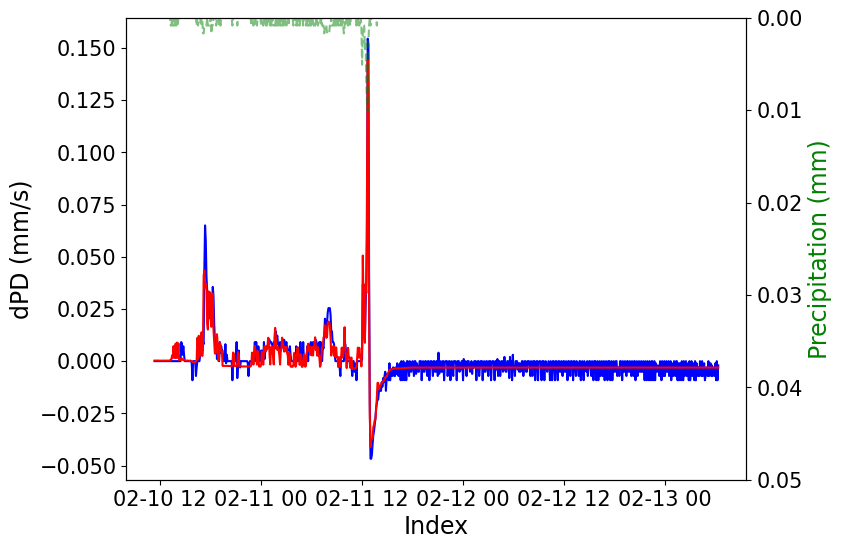

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the actual values in blue
ax.plot(y_specific_event.index, y_specific_event, label='Actual', color='blue')

# Plot the predicted values in red
ax.plot(y_specific_event.index, y_pred_specific_event, label='Predicted', color='red')

# Update font sizes to match the first snippet
ax.set_xlabel("Index", fontsize=17)
ax.set_ylabel("dPD (mm/s)", fontsize=17)
ax.tick_params(axis='both', which='major', labelsize=15)
# ax.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0), fontsize=17)

# Create a secondary y-axis for 'Precipitation'
ax2 = ax.twinx()
ax2.invert_yaxis()  # Invert the y-axis for 'Precipitation'
ax2.set_ylim(0.05, 0)  # Set the limits for 'Precipitation' y-axis

# Plot 'Precipitation' on the secondary y-axis
precipitation_event = df.loc[y_specific_event.index, 'Precipitation (mm)']
ax2.plot(precipitation_event.index, precipitation_event, color='green', alpha=0.5, label='Precipitation', linestyle='--')
ax2.set_ylabel('Precipitation (mm)', fontsize=17, color='green')
ax2.tick_params(axis='both', which='major', labelsize=15)
# ax2.legend(loc='upper right', bbox_to_anchor=(1.0, 0.85), fontsize=17)

plt.show()

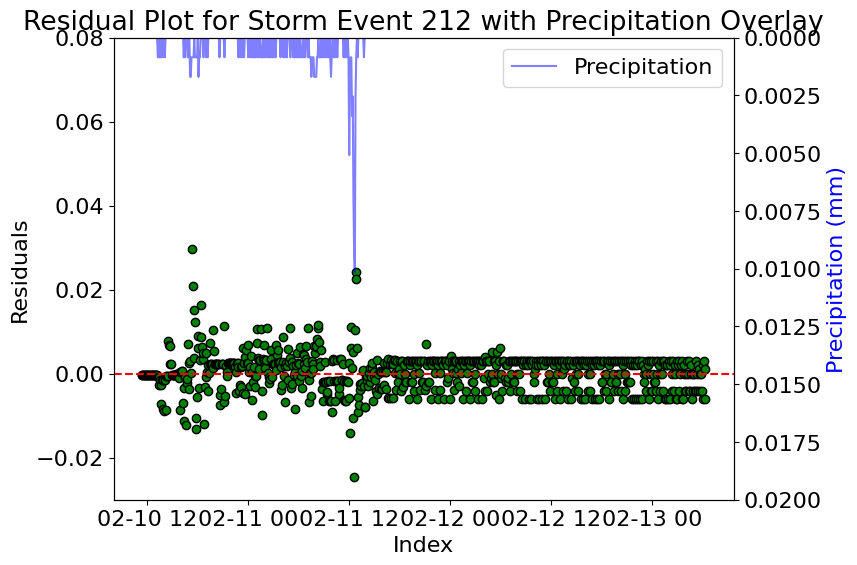

In [ ]:
# Calculate the residuals for the specific event
residuals_specific_event = y_specific_event - y_pred_specific_event

# Create a scatter plot of residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_specific_event.index, residuals_specific_event, c='green', edgecolors='k', label='Residuals')
plt.xlabel("Index")
plt.ylabel("Residuals")
plt.title("Residual Plot for Storm Event 212 with Precipitation Overlay")
plt.axhline(y=0, color='red', linestyle='--')
plt.ylim(-0.03, 0.08)

# Create a secondary y-axis for 'Precipitation'
ax2 = plt.gca().twinx()
ax2.invert_yaxis()  # Invert the y-axis for 'Precipitation'
ax2.set_ylim(0.02, 0)  # Set the limits for 'Precipitation' y-axis

# Plot 'Precipitation' on the secondary y-axis
precipitation_event = df.loc[y_specific_event.index, 'Precipitation (mm)']
ax2.plot(precipitation_event.index, precipitation_event, color='blue', alpha=0.5, label='Precipitation')

ax2.set_ylabel('Precipitation (mm)', color='blue')

# Add legends for both axes
plt.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

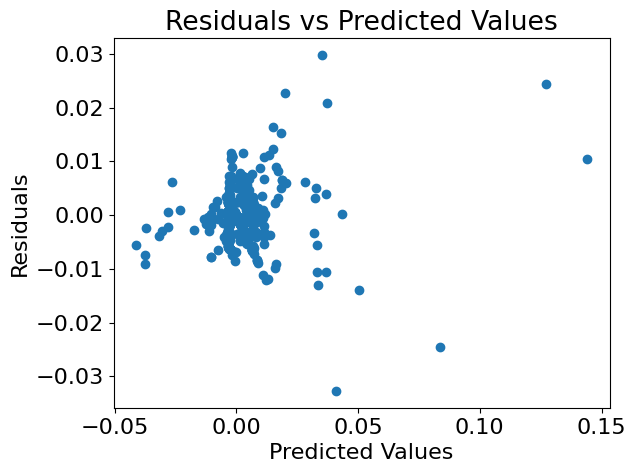

In [ ]:
plt.scatter(y_pred_specific_event, residuals)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")

plt.show()

# Performance by seasons and peak rainfall intensity

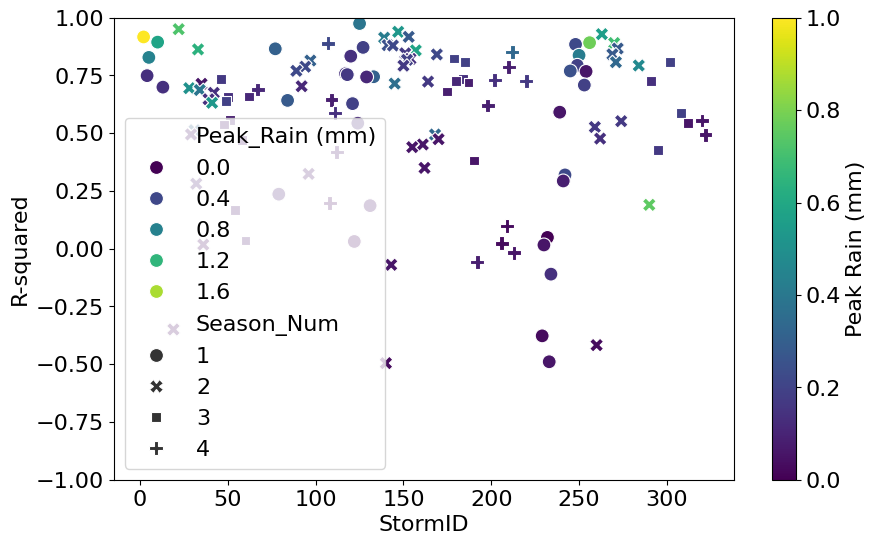

In [ ]:
df1 = df.copy()

# Store results in a list for efficiency
performance_results = []

# Iterate through unique storm events
for event in train_storm_events:
    specific_event_df = df[df['StormID'] == event]

    # Check if data exists for this event
    if specific_event_df.empty:
        continue

    # Extract features and target
    X_specific = specific_event_df[input_columns]
    y_specific = specific_event_df[target_column]

    # Standardize features
    X_specific_scaled = scaler.transform(X_specific)

    # Make predictions
    y_pred_specific = model.predict(X_specific_scaled)

    # Compute performance metrics
    mse = mean_squared_error(y_specific, y_pred_specific)
    r2 = r2_score(y_specific, y_pred_specific)

    # Store results
    performance_results.append([event, mse, r2])

# Convert results to DataFrame
performance_results_train = pd.DataFrame(performance_results, columns=['StormID', 'MSE', 'R-squared'])

# Sort by R-squared in descending order
performance_results_train.sort_values(by='R-squared', ascending=False, inplace=True)

# Extract first datetime for each StormID
first_datetime_by_storm = df.reset_index().groupby('StormID')['Datetime'].min().reset_index()

# Merge datasets
merged_dataset_train = performance_results_train.merge(first_datetime_by_storm, on='StormID', how='left')

# Set Datetime as index
merged_dataset_train.set_index('Datetime', inplace=True)

# Drop last row safely
if not merged_dataset_train.empty:
    merged_dataset_train.drop(merged_dataset_train.index[-1], inplace=True)

# Merge with additional dataset (df1) on StormID
result_dataset_train = merged_dataset_train.merge(df1, on='StormID', how='left')

# Keep only relevant columns
result_dataset_train = result_dataset_train[['StormID', 'MSE', 'R-squared',
                                             'Accumulated_Rain (mm)', 'Peak_Rain (mm)',
                                             'Mean_Rain (mm)', 'Year', 'Season_Num']]

# Drop duplicate StormIDs
result_dataset_train.drop_duplicates(subset=['StormID'], inplace=True)

# Plot
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=result_dataset_train, x='StormID', y='R-squared',
    hue='Peak_Rain (mm)', style='Season_Num', palette='viridis',
    s=100
)

# Add color bar for 'Peak_Rain (mm)'
plt.colorbar(scatter.collections[0], label='Peak Rain (mm)')

# Set labels and limits
plt.xlabel("StormID")
plt.ylabel("R-squared")
plt.ylim(-1, 1)

# Show plot
plt.show()

Test set

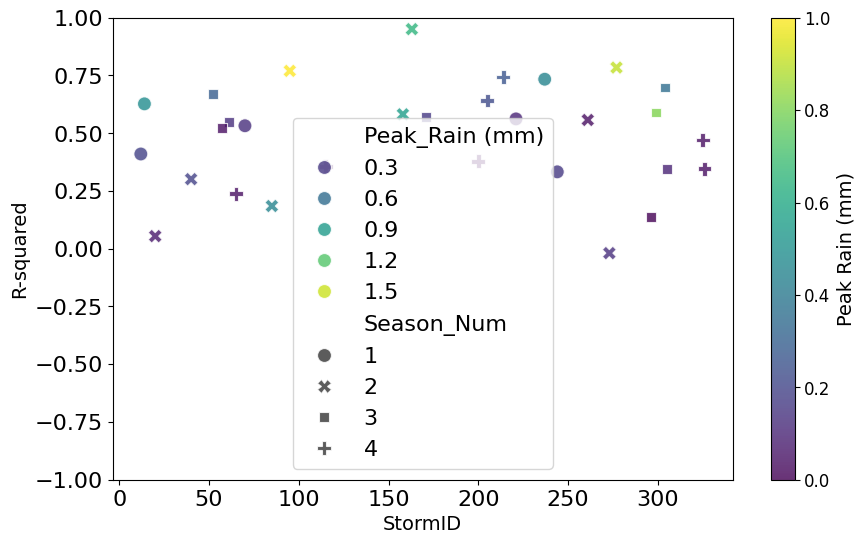

In [ ]:
# Store results in a list for efficiency
performance_results = []

# Iterate through unique storm events in the test set
for event in test_storm_events:
    specific_event_df = df[df['StormID'] == event]

    # Check if data exists for this event
    if specific_event_df.empty:
        continue

    # Extract input features and target
    X_specific = specific_event_df[input_columns]
    y_specific = specific_event_df[target_column]

    # Standardize input features
    X_specific_scaled = scaler.transform(X_specific)

    # Make predictions
    y_pred_specific = model.predict(X_specific_scaled)

    # Compute model performance metrics
    mse = mean_squared_error(y_specific, y_pred_specific)
    r2 = r2_score(y_specific, y_pred_specific)

    # Append results to the list
    performance_results.append([event, mse, r2])

# Convert results list to DataFrame
performance_results_test = pd.DataFrame(performance_results, columns=['StormID', 'MSE', 'R-squared'])

# Sort by R-squared in descending order
performance_results_test.sort_values(by='R-squared', ascending=False, inplace=True)

# Extract first datetime for each StormID
first_datetime_by_storm = df.reset_index().groupby('StormID')['Datetime'].min().reset_index()

# Merge datasets
merged_dataset_test = performance_results_test.merge(first_datetime_by_storm, on='StormID', how='left')

# Set Datetime as index
merged_dataset_test.set_index('Datetime', inplace=True)

# Drop last row safely
if not merged_dataset_test.empty:
    merged_dataset_test.drop(merged_dataset_test.index[-1], inplace=True)

# Merge with additional dataset (df) on StormID
result_dataset_test = merged_dataset_test.merge(df, on='StormID', how='left')

# Select relevant columns
result_dataset_test = result_dataset_test[['StormID', 'MSE', 'R-squared',
                                           'Accumulated_Rain (mm)', 'Peak_Rain (mm)',
                                           'Mean_Rain (mm)', 'Year', 'Season_Num']]

# Drop duplicate StormIDs
result_dataset_test.drop_duplicates(subset=['StormID'], inplace=True)

# Create figure
plt.figure(figsize=(10, 6))

# Scatter plot
scatter = sns.scatterplot(
    data=result_dataset_test, x='StormID', y='R-squared',
    hue='Peak_Rain (mm)', style='Season_Num', palette='viridis',
    s=100, alpha=0.8
)

# Add color bar using the scatter plot's color mapping
cbar = plt.colorbar(scatter.collections[0])
cbar.set_label("Peak Rain (mm)", fontsize=14)
cbar.ax.tick_params(labelsize=12)

# Set labels and limits
plt.xlabel("StormID", fontsize=14)
plt.ylabel("R-squared", fontsize=14)
plt.ylim(-1, 1)  # Limit R² to [-1,1] for better readability

# Show plot
plt.show()

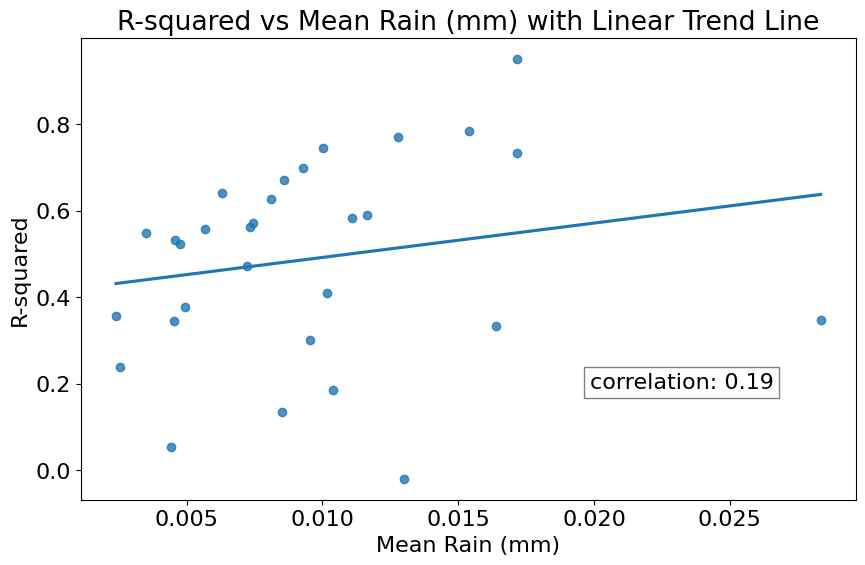

In [ ]:
# Storm-specific model performance vs mean rain

plt.figure(figsize=(10, 6))
reg_plot = sns.regplot(data=result_dataset_test, x='Mean_Rain (mm)', y='R-squared', ci=None)  # ci=None removes the confidence interval

correlation = result_dataset_test['Mean_Rain (mm)'].corr(result_dataset_test['R-squared'])

# Adding a text box with the correlation value
plt.text(x=max(result_dataset_test['Mean_Rain (mm)']) * 0.7,  # Position the text at 70% of the max x-value
         y=max(result_dataset_test['R-squared']) * 0.2,       # Position the text at 90% of the max y-value
         s=f'correlation: {correlation:.2f}',
         bbox=dict(facecolor='white', alpha=0.5))

# Setting plot title and labels
plt.title('R-squared vs Mean Rain (mm) with Linear Trend Line')
plt.xlabel('Mean Rain (mm)')
plt.ylabel('R-squared')

# Showing the plot
plt.show()

In [ ]:
# Adding a new column to each dataset to indicate whether it's from train or test
result_dataset_train['Type'] = 'train'
result_dataset_test['Type'] = 'test'

# Merging the datasets vertically
merged_dataset = pd.concat([result_dataset_train, result_dataset_test], ignore_index=True)

In [ ]:
print(list(merged_dataset))

['StormID', 'MSE', 'R-squared', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'Year', 'Season_Num', 'Type']


In [ ]:
# Determine thresholds for 'Accumulated_Rain (mm)'
thresholds = merged_dataset['Accumulated_Rain (mm)'].quantile([0.33, 0.66]).values

# Function to categorize storms
def categorize_storm(rainfall):
    if rainfall <= thresholds[0]:
        return 'small'
    elif rainfall <= thresholds[1]:
        return 'medium'
    else:
        return 'large'

# Apply the function to categorize storms
merged_dataset['Storm_Category'] = merged_dataset['Accumulated_Rain (mm)'].apply(categorize_storm)

merged_dataset

,StormID,MSE,R-squared,Accumulated_Rain (mm),Peak_Rain (mm),Mean_Rain (mm),Year,Season_Num,Type,Storm_Category
0,125.0,0.000021,0.960595,1.5748,0.7112,0.011013,2017,1,train,small
1,147.0,0.000038,0.941609,8.7884,0.9652,0.024756,2017,2,train,large
2,263.0,0.000028,0.934331,13.8684,1.0160,0.019840,2018,2,train,large
3,153.0,0.000019,0.929078,1.7780,0.5080,0.008759,2017,2,train,small
4,139.0,0.000064,0.907586,3.0988,0.7620,0.013959,2017,2,train,medium
...,...,...,...,...,...,...,...,...,...,...
110,200.0,0.000033,0.300553,1.0160,0.1016,0.004956,2017,4,test,small
111,115.0,0.000017,0.289215,0.8636,0.0508,0.002399,2017,4,test,small
112,65.0,0.000020,0.170872,1.8796,0.1016,0.002540,2014,4,test,small
113,296.0,0.000027,0.156972,2.1844,0.0508,0.008500,2018,3,test,medium


In [ ]:
merged_dataset_train = merged_dataset[merged_dataset['Type'] == 'train']
merged_dataset_test = merged_dataset[merged_dataset['Type'] == 'test']

Trainset

In [ ]:
# Calculating the mean R-squared value for each storm category
mean_r_squared_by_category = merged_dataset_train.groupby('Storm_Category')['R-squared'].mean()
print(mean_r_squared_by_category)

Storm_Category
large     0.774138
medium    0.700816
small     0.496973
Name: R-squared, dtype: float64


In [ ]:
mean_r_squared_by_category = merged_dataset_train.groupby('Year')['R-squared'].mean()
print(mean_r_squared_by_category)

Year
2014    0.645713
2015    0.674202
2017    0.741381
2018    0.545299
Name: R-squared, dtype: float64


In [ ]:
mean_r_squared_by_category = merged_dataset_train.groupby('Season_Num')['R-squared'].mean()
print(mean_r_squared_by_category)

Season_Num
1    0.650683
2    0.703797
3    0.627133
4    0.532977
Name: R-squared, dtype: float64


Testset

In [ ]:
# Calculating the mean R-squared value for each storm category
mean_r_squared_by_category = merged_dataset_test.groupby('Storm_Category')['R-squared'].mean()
print(mean_r_squared_by_category)

Storm_Category
large     0.583081
medium    0.471156
small     0.198912
Name: R-squared, dtype: float64


In [ ]:
mean_r_squared_by_category = merged_dataset_test.groupby('Year')['R-squared'].mean()
print(mean_r_squared_by_category)

Year
2014    0.473474
2015    0.501975
2017    0.389003
2018    0.447109
Name: R-squared, dtype: float64


In [ ]:
mean_r_squared_by_category = merged_dataset_test.groupby('Season_Num')['R-squared'].mean()
print(mean_r_squared_by_category)

Season_Num
1    0.523980
2    0.331784
3    0.517313
4    0.413577
Name: R-squared, dtype: float64


In [ ]:
result_dataset_train['Type'] = 'train'
result_dataset_test['Type'] = 'test'

# Merge the datasets vertically
merged_dataset = pd.concat([result_dataset_train, result_dataset_test], ignore_index=True)

# Define thresholds for 'Accumulated_Rain (mm)'
thresholds = merged_dataset['Accumulated_Rain (mm)'].quantile([0.33, 0.66]).values

# Function to categorize storms based on accumulated rainfall
def categorize_storm(rainfall):
    if np.isnan(rainfall):
        return 'unknown'  # Handle missing values
    elif rainfall <= thresholds[0]:
        return 'small'
    elif rainfall <= thresholds[1]:
        return 'medium'
    else:
        return 'large'

# Apply storm categorization
merged_dataset['Storm_Category'] = merged_dataset['Accumulated_Rain (mm)'].apply(categorize_storm)

# Split the dataset into train and test subsets
merged_dataset_train = merged_dataset[merged_dataset['Type'] == 'train']
merged_dataset_test = merged_dataset[merged_dataset['Type'] == 'test']

# Function to compute mean R² by different categories
def compute_mean_r_squared(df, group_by_columns):
    return {col: df.groupby(col)['R-squared'].mean().to_dict() for col in group_by_columns}

# Define grouping categories
grouping_columns = ['Storm_Category', 'Year', 'Season_Num']

# Compute mean R² for train and test sets
mean_r_squared_train = compute_mean_r_squared(merged_dataset_train, grouping_columns)
mean_r_squared_test = compute_mean_r_squared(merged_dataset_test, grouping_columns)

# Print results
print("Train Set Mean R-squared by Category:")
for category, values in mean_r_squared_train.items():
    print(f"{category}:\n{values}\n")

print("Test Set Mean R-squared by Category:")
for category, values in mean_r_squared_test.items():
    print(f"{category}:\n{values}\n")

Train Set Mean R-squared by Category:
Storm_Category:
{'large': 0.7634691677397032, 'medium': 0.696767993590532, 'small': -1.9964690818074462}

Year:
{2014: 0.44516773356752026, 2015: 0.32567607004664545, 2017: 0.6184732637145914, 2018: -1.9227892106322098}

Season_Num:
{1: 0.3746392391628966, 2: 0.5972965825468254, 3: -3.829298518595395, 4: 0.4843776292657097}

Test Set Mean R-squared by Category:
Storm_Category:
{'large': 0.5959846504342439, 'medium': 0.4273872967954926, 'small': 0.21439847316838062}

Year:
{2014: 0.4217300099731671, 2015: 0.49568948814743913, 2017: 0.5677166152765285, 2018: 0.4945241554984066}

Season_Num:
{1: 0.5330005735794419, 2: 0.46285602306025414, 3: 0.5102798983016664, 4: 0.45384042316510265}



#Temporal Range

<ipython-input-82-4ac07d20ee7b>:199: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_df = df.groupby('StormID').resample(interval).sum(numeric_only=True)
<ipython-input-82-4ac07d20ee7b>:199: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_df = df.groupby('StormID').resample(interval).sum(numeric_only=True)
<ipython-input-82-4ac07d20ee7b>:199: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_df = df.groupby('StormID').resample(interval).sum(numeric_only=True)
<ipython-input-82-4ac07d20ee7b>:199: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_df = df.groupby('StormID').resample(interval).sum(numeric_only=True)
<ipython-input-82-4ac07d20ee7b>:199: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' in

         Label       MSE      RMSE       MAE  R² Score       EVS
0    Train Set  0.000035  0.005878  0.003245  0.795342  0.795342
1     Test Set  0.000084  0.009139  0.003760  0.611408  0.611665
2  Train (15T)  0.000121  0.010984  0.004797  0.874674  0.874674
3  Train (30T)  0.000284  0.016840  0.006958  0.902617  0.902617
4   Train (1H)  0.000707  0.026586  0.011278  0.915352  0.915352
5   Test (15T)  0.000319  0.017861  0.007416  0.759673  0.760027
6   Test (30T)  0.000829  0.028795  0.011906  0.798586  0.799038
7    Test (1H)  0.002133  0.046184  0.020972  0.809917  0.810565


<ipython-input-82-4ac07d20ee7b>:223: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  train_df.groupby('StormID').resample('15T').sum(numeric_only=True)['y_pred_train'], "Train (15T)")
<ipython-input-82-4ac07d20ee7b>:224: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  plot_scatter_subplot(axes[0, 2], train_df.groupby('StormID').resample('30T').sum(numeric_only=True)['Recession_Rate (mm/s)'],
<ipython-input-82-4ac07d20ee7b>:225: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  train_df.groupby('StormID').resample('30T').sum(numeric_only=True)['y_pred_train'], "Train (30T)")
<ipython-input-82-4ac07d20ee7b>:226: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  plot_scatter_subplot(axes[0, 3], train_df.groupby('StormID').resample('1H').sum(numeric_only=True)['Recession_Rate (mm/s)'

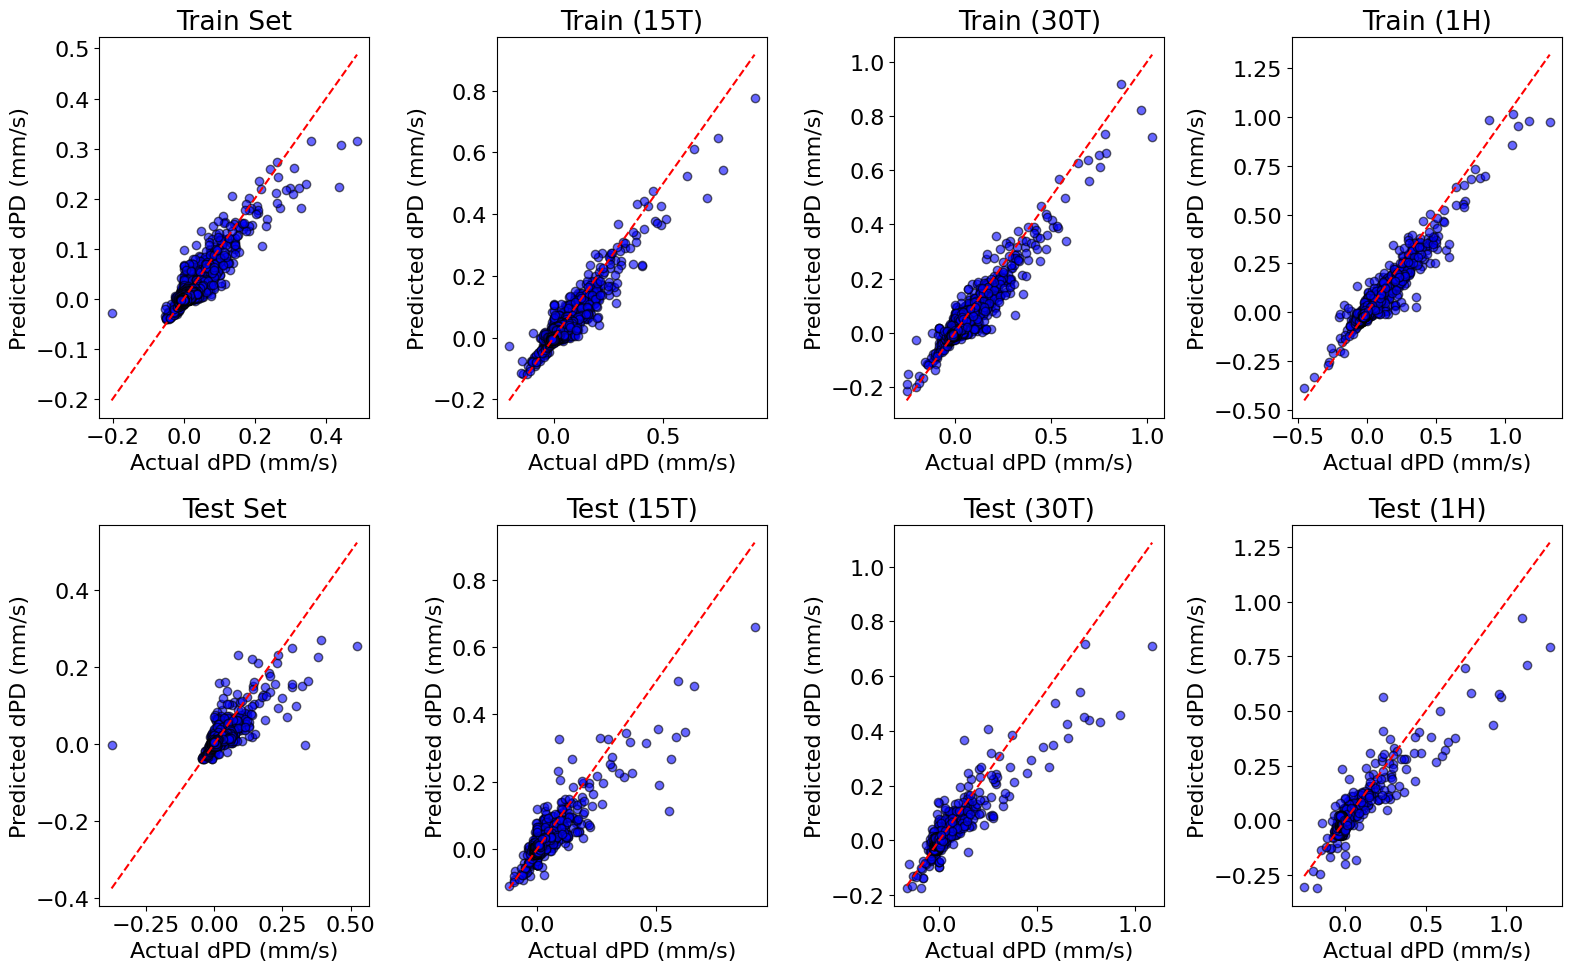

In [ ]:
# Define a function to compute performance metrics
def compute_metrics(y_true, y_pred, label):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    evs = explained_variance_score(y_true, y_pred)

    return [label, mse, rmse, mae, r2, evs]

# Store results in a DataFrame
results = []

# Train Set Evaluation
y_pred_train = model.predict(X_train_scaled)
train_df['y_pred_train'] = y_pred_train
results.append(compute_metrics(y_train, y_pred_train, "Train Set"))

# Test Set Evaluation
y_pred_test = model.predict(X_test_scaled)
test_df['y_pred_test'] = y_pred_test
results.append(compute_metrics(y_test, y_pred_test, "Test Set"))

# Resampling and Evaluation
for df, pred_col, name in zip([train_df, test_df], ['y_pred_train', 'y_pred_test'], ["Train", "Test"]):
    for interval in ['15T', '30T', '1H']:
        resampled_df = df.groupby('StormID').resample(interval).sum(numeric_only=True)
        if pred_col in resampled_df:
            results.append(compute_metrics(resampled_df['Recession_Rate (mm/s)'], resampled_df[pred_col], f"{name} ({interval})"))

# Convert results into a DataFrame
results_df = pd.DataFrame(results, columns=["Label", "MSE", "RMSE", "MAE", "R² Score", "EVS"])
print(results_df)

# --- PLOTTING ---

# Define a function to create scatter plots in subplots
def plot_scatter_subplot(ax, actual, predicted, title):
    ax.scatter(actual, predicted, c='blue', edgecolors='k', alpha=0.6)
    ax.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--')
    ax.set_xlabel("Actual dPD (mm/s)")
    ax.set_ylabel("Predicted dPD (mm/s)")
    ax.set_title(title)

# Create a 2x4 subplot layout
fig, axes = plt.subplots(2, 4, figsize=(16, 10))

# Plot for Train (Original, 15T, 30T, 1H)
plot_scatter_subplot(axes[0, 0], train_df['Recession_Rate (mm/s)'], train_df['y_pred_train'], "Train Set")
plot_scatter_subplot(axes[0, 1], train_df.groupby('StormID').resample('15T').sum(numeric_only=True)['Recession_Rate (mm/s)'],
                     train_df.groupby('StormID').resample('15T').sum(numeric_only=True)['y_pred_train'], "Train (15T)")
plot_scatter_subplot(axes[0, 2], train_df.groupby('StormID').resample('30T').sum(numeric_only=True)['Recession_Rate (mm/s)'],
                     train_df.groupby('StormID').resample('30T').sum(numeric_only=True)['y_pred_train'], "Train (30T)")
plot_scatter_subplot(axes[0, 3], train_df.groupby('StormID').resample('1H').sum(numeric_only=True)['Recession_Rate (mm/s)'],
                     train_df.groupby('StormID').resample('1H').sum(numeric_only=True)['y_pred_train'], "Train (1H)")

# Plot for Test (Original, 15T, 30T, 1H)
plot_scatter_subplot(axes[1, 0], test_df['Recession_Rate (mm/s)'], test_df['y_pred_test'], "Test Set")
plot_scatter_subplot(axes[1, 1], test_df.groupby('StormID').resample('15T').sum(numeric_only=True)['Recession_Rate (mm/s)'],
                     test_df.groupby('StormID').resample('15T').sum(numeric_only=True)['y_pred_test'], "Test (15T)")
plot_scatter_subplot(axes[1, 2], test_df.groupby('StormID').resample('30T').sum(numeric_only=True)['Recession_Rate (mm/s)'],
                     test_df.groupby('StormID').resample('30T').sum(numeric_only=True)['y_pred_test'], "Test (30T)")
plot_scatter_subplot(axes[1, 3], test_df.groupby('StormID').resample('1H').sum(numeric_only=True)['Recession_Rate (mm/s)'],
                     test_df.groupby('StormID').resample('1H').sum(numeric_only=True)['y_pred_test'], "Test (1H)")

# Adjust layout and show
plt.tight_layout()
plt.show()

#Model performance for year, season and storm size

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score

# Convert predictions to Pandas Series and add them to the DataFrame
train_df['Predicted_Recession_Rate'] = pd.Series(y_pred_train.flatten(), index=train_df.index)
test_df['Predicted_Recession_Rate'] = pd.Series(y_pred_test.flatten(), index=test_df.index)

# Define storm size quantiles
quantiles_train = train_df['Accumulated_Rain (mm)'].quantile([0.33, 0.66])
quantiles_test = test_df['Accumulated_Rain (mm)'].quantile([0.33, 0.66])

# Function to categorize storm size
def categorize_storm_size(row, quantiles):
    if row['Accumulated_Rain (mm)'] <= quantiles.iloc[0]:
        return 'Small'
    elif row['Accumulated_Rain (mm)'] <= quantiles.iloc[1]:
        return 'Medium'
    else:
        return 'Large'

# Apply categorization function
train_df['Storm_Size'] = train_df.apply(lambda row: categorize_storm_size(row, quantiles_train), axis=1)
test_df['Storm_Size'] = test_df.apply(lambda row: categorize_storm_size(row, quantiles_test), axis=1)

# Group by 'Storm_Size' and count unique 'StormID's
storm_count_train = train_df.groupby('Storm_Size')['StormID'].nunique()
storm_count_test = test_df.groupby('Storm_Size')['StormID'].nunique()

# Group by 'Storm_Size' and calculate min/max of 'Accumulated_Rain (mm)'
storm_size_ranges_train = train_df.groupby('Storm_Size')['Accumulated_Rain (mm)'].agg(['min', 'max'])
storm_size_ranges_test = test_df.groupby('Storm_Size')['Accumulated_Rain (mm)'].agg(['min', 'max'])

# Display results
print("\nUnique Storm Counts by Size (Train Set):\n", storm_count_train)
print("\nStorm Size Ranges (Train Set):\n", storm_size_ranges_train)
print("\nUnique Storm Counts by Size (Test Set):\n", storm_count_test)
print("\nStorm Size Ranges (Test Set):\n", storm_size_ranges_test)

# Function to calculate R² scores for grouped data
def calculate_r2_for_groups(df, group_column):
    return df.groupby(group_column).apply(lambda g: r2_score(g['Recession_Rate (mm/s)'], g['Predicted_Recession_Rate']))

# Calculate R² scores by Year, Season_Num, and Storm_Size for Train & Test sets
r2_scores = {
    "Train - Year": calculate_r2_for_groups(train_df, 'Year'),
    "Test - Year": calculate_r2_for_groups(test_df, 'Year'),
    "Train - Season_Num": calculate_r2_for_groups(train_df, 'Season_Num'),
    "Test - Season_Num": calculate_r2_for_groups(test_df, 'Season_Num'),
    "Train - Storm_Size": calculate_r2_for_groups(train_df, 'Storm_Size'),
    "Test - Storm_Size": calculate_r2_for_groups(test_df, 'Storm_Size')
}

# Display R² scores
for key, value in r2_scores.items():
    print(f"\nR² Scores by {key}:\n", value)


Unique Storm Counts by Size (Train Set):
 Storm_Size
Large     16
Medium    26
Small     84
Name: StormID, dtype: int64

Storm Size Ranges (Train Set):
                min      max
Storm_Size                 
Large       6.8072  25.7048
Medium      3.2004   6.2992
Small       0.0000   3.1496

Unique Storm Counts by Size (Test Set):
 Storm_Size
Large      6
Medium     9
Small     16
Name: StormID, dtype: int64

Storm Size Ranges (Test Set):
                min      max
Storm_Size                 
Large       7.3152  16.3068
Medium      3.9116   6.6548
Small       0.8636   3.8608

R² Scores by Train - Year:
 Year
2014    0.814438
2015    0.822579
2017    0.811385
2018    0.765704
dtype: float64

R² Scores by Test - Year:
 Year
2014    0.366420
2015    0.664224
2017    0.711292
2018    0.660247
dtype: float64

R² Scores by Train - Season_Num:
 Season_Num
1    0.837598
2    0.827925
3    0.617317
4    0.717053
dtype: float64

R² Scores by Test - Season_Num:
 Season_Num
1    0.619071
2    

<ipython-input-84-cd335dce6525>:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_column).apply(lambda g: r2_score(g['Recession_Rate (mm/s)'], g['Predicted_Recession_Rate']))
<ipython-input-84-cd335dce6525>:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_column).apply(lambda g: r2_score(g['Recession_Rate (mm/s)'], g['Predicted_Recession_Rate']))
<ipython-inp

In [ ]:
# Define the data for the dataframe
data_year = {
    'Year': [2014, 2015, 2017, 2018, 2014, 2015, 2017, 2018],
    'LR': [0.32, 0.63, 0.68, 0.55, 0.50, 0.42, 0.61, 0.47],
    'RF': [0.36, 0.66, 0.70, 0.66, 0.81, 0.82, 0.811, 0.76],
    'DDLSTM': [0.42, 0.44, 0.61, 0.53, 0.57, 0.65, 0.78, 0.61],  # Replace None with actual DDLSTM data
    'PILSTM': [0.38, 0.42, 0.66, 0.54, 0.59, 0.68, 0.82, 0.63],  # Replace None with actual PILSTM data
    'Sample': ['Test', 'Test', 'Test', 'Test', 'Train', 'Train', 'Train', 'Train']
}

# Create the dataframe
df_year = pd.DataFrame(data_year)

# Data from the image provided by the user
data_season = {
    'Season': [1, 2, 3, 4, 1, 2, 3, 4],
    'LR': [0.55, 0.56, 0.51, 0.48, 0.61, 0.50, 0.29, 0.44],
    'RF': [0.62, 0.61, 0.60, 0.60, 0.83, 0.82, 0.61, 0.72],
    'DDLSTM': [0.69, 0.67, 0.62, 0.63, 0.74, 0.76, 0.64, 0.80],  # Placeholder for missing DDLSTM data
    'PILSTM': [0.70, 0.71, 0.60, 0.64, 0.75, 0.78, 0.61, 0.79],  # Placeholder for missing PILSTM data
    'Sample': ['Test', 'Test', 'Test', 'Test', 'Train', 'Train', 'Train', 'Train']
}

# Create the DataFrame
df_season = pd.DataFrame(data_season)

# Data from the image provided by the user
data_storm_size = {
    'Storm Size': ['Large', 'Medium', 'Small', 'Large', 'Medium', 'Small'],
    'LR': [0.30, 0.32, 0.31, 0.36, 0.40, 0.43],
    'RF': [0.65, 0.68, 0.48, 0.80, 0.82, 0.74],
    'DDLSTM': [0.71, 0.78, 0.46, 0.81, 0.83, 0.82],  # Placeholder for missing DDLSTM data
    'PILSTM': [0.73, 0.80, 0.49, 0.81, 0.85, 0.87],  # Placeholder for missing PILSTM data
    'Sample': ['Test', 'Test', 'Test', 'Train', 'Train', 'Train']
}

# Create the DataFrame
df_storm_size = pd.DataFrame(data_storm_size)


# Define the complete data for the dataframe as provided by the user for the temporal resolution dataset
data_temporal_resolution = {
    'Temporal Resolution': [5, 15, 30, 60]*2,  # Two sets for Train and Test
    'LR': [0.51, 0.66, 0.73, 0.76, 0.44, 0.58, 0.82, -0.14],  # Train followed by Test
    'RF': [0.79, 0.87, 0.9, 0.91, 0.73, 0.72, 0.83, 0.23],  # Train followed by Test
    'DDLSTM': [0.87, 0.85, 0.87, 0.87, 0.82, 0.8, 0.93, 0.1],  # Train followed by Test
    'PILSTM': [0.9, 0.91, 0.91, 0.89, 0.86, 0.85, 0.95, 0.14],  # Train followed by Test
    'Sample': ['Train']*4 + ['Test']*4  # Identifying the sample type
}

# Create the dataframe with the temporal resolution data
df_temporal_resolution = pd.DataFrame(data_temporal_resolution)

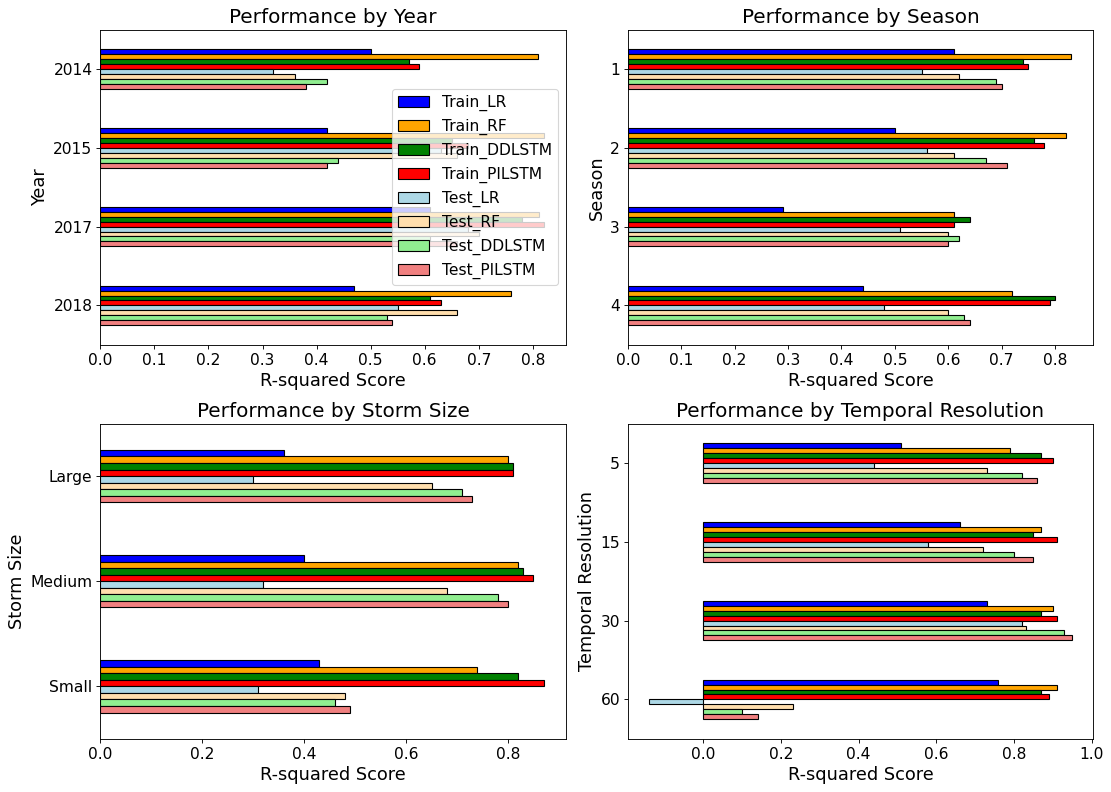

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df_year, df_season, df_storm_size, df_temporal_resolution are defined
# ...

# Adjusting the plot to make Train and Test more distinct by using color shades
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10), dpi=80)

# Titles for the subplots
titles = ['Performance by Year', 'Performance by Season', 'Performance by Storm Size', 'Performance by Temporal Resolution']

# DataFrames list
dataframes = [df_year, df_season, df_storm_size, df_temporal_resolution]

# Colors for the different models (darker for Train, lighter for Test)
colors_train = ['blue', 'orange', 'green', 'red']
colors_test = ['lightblue', 'navajowhite', 'lightgreen', 'lightcoral']

# Iterate over each subplot and dataframe
for i, (ax, title, df) in enumerate(zip(axes.flatten(), titles, dataframes)):
    # Split the dataframe into Test and Train
    df_test = df[df['Sample'] == 'Test'].drop(columns='Sample').set_index(df.columns[0])
    df_train = df[df['Sample'] == 'Train'].drop(columns='Sample').set_index(df.columns[0])

    # Concatenate Test and Train dataframes for side-by-side bars
    df_combined = pd.concat([df_train, df_test], axis=1, keys=['Train', 'Test'])
    df_combined.columns = df_combined.columns.map('_'.join)

    # Plotting
    df_combined.plot(kind='barh', ax=ax, color=colors_train + colors_test, edgecolor='black')

    # Set titles, labels, and tick parameters with increased font sizes
    ax.set_title(title, fontsize=18)
    ax.set_xlabel('R-squared Score', fontsize=16)
    ax.set_ylabel(df.columns[0], fontsize=16)  # Assuming the first column is the one to use for y-axis labels
    ax.tick_params(axis='both', which='major', labelsize=14)

    # Invert y-axis to have the top bar represent the first row in the dataframe
    ax.invert_yaxis()

    # Set legend: Only for the first subplot, remove legend for others
    if i == 0:
        ax.legend(fontsize=14)
    else:
        ax.legend().remove()

# Adjust layout to prevent overlap
fig.tight_layout()

# Display the plot
plt.show()

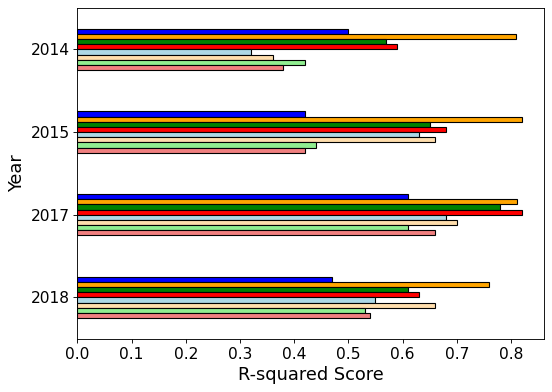

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df_year is defined and structured with the first column as 'storm_size', followed by numeric columns 'LR', 'RF', 'DDLSTM', 'PILSTM', and 'Sample' as the last column

# Adjusting the plot to make Train and Test more distinct by using color shades
fig, ax = plt.subplots(figsize=(7, 5), dpi=80)  # Adjust the size as needed

# Title for the subplot
# title = 'Performance by storm_size'

# Colors for the different models (darker for Train, lighter for Test)
colors_train = ['blue', 'orange', 'green', 'red']
colors_test = ['lightblue', 'navajowhite', 'lightgreen', 'lightcoral']

# Split the dataframe into Test and Train
df_test = df_year[df_year['Sample'] == 'Test'].drop(columns='Sample').set_index('Year')
df_train = df_year[df_year['Sample'] == 'Train'].drop(columns='Sample').set_index('Year')

# Concatenate Test and Train dataframes for side-by-side bars
df_combined = pd.concat([df_train, df_test], axis=1, keys=['Train', 'Test'])
df_combined.columns = df_combined.columns.map('_'.join)

# Plotting
df_combined.plot(kind='barh', ax=ax, color=colors_train + colors_test, edgecolor='black')

# Set title, labels, and tick parameters with increased font sizes
# ax.set_title(title, fontsize=18)
ax.set_xlabel('R-squared Score', fontsize=16)
ax.set_ylabel('Year', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)

# Invert y-axis to have the top bar represent the first row in the dataframe
ax.invert_yaxis()

# Remove the legend
ax.get_legend().remove()

# Adjust layout to prevent overlap
fig.tight_layout()

# Display the plot
plt.show()

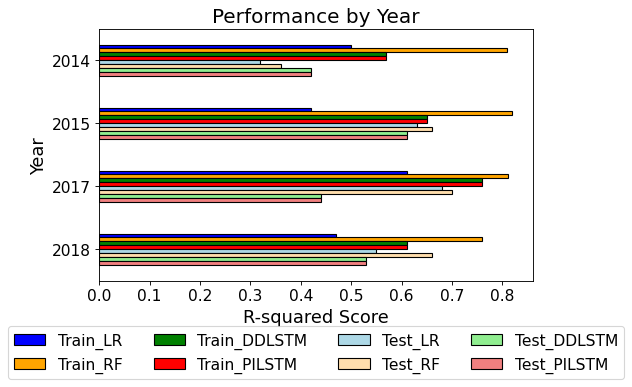

In [ ]:
# Adjusting the plot to make Train and Test more distinct by using color shades
fig, ax = plt.subplots(figsize=(7, 5), dpi=80)  # Adjust the size as needed

# Title for the subplot
title = 'Performance by Year'

# Colors for the different models (darker for Train, lighter for Test)
colors_train = ['blue', 'orange', 'green', 'red']
colors_test = ['lightblue', 'navajowhite', 'lightgreen', 'lightcoral']

# Split the dataframe into Test and Train
df_test = df_year[df_year['Sample'] == 'Test'].drop(columns='Sample').set_index('Year')
df_train = df_year[df_year['Sample'] == 'Train'].drop(columns='Sample').set_index('Year')

# Concatenate Test and Train dataframes for side-by-side bars
df_combined = pd.concat([df_train, df_test], axis=1, keys=['Train', 'Test'])
df_combined.columns = df_combined.columns.map('_'.join)

# Plotting
bars = df_combined.plot(kind='barh', ax=ax, color=colors_train + colors_test, edgecolor='black')

# Set title, labels, and tick parameters with increased font sizes
ax.set_title(title, fontsize=18)
ax.set_xlabel('R-squared Score', fontsize=16)
ax.set_ylabel('Year', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)

# Invert y-axis to have the top bar represent the first row in the dataframe
ax.invert_yaxis()

# Place a legend below the plot, horizontally, with increased font size
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize=14)  # Adjust fontsize as needed

# Adjust the bottom margin to make room for the legend
plt.subplots_adjust(bottom=0.25)  # Adjust the bottom margin as needed

# Display the plot
plt.show()

#HP tuning

In [ ]:
# from sklearn.model_selection import GridSearchCV

# # Define the hyperparameters and their possible values
# param_grid = {
#     'n_estimators': [50, 100, 150],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # Create a Random Forest regressor
# rf_model = RandomForestRegressor(random_state=0)

# # Create GridSearchCV object
# grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# # Fit the model to the training data
# grid_search.fit(X_train, y_train)

# # Get the best hyperparameters from the grid search
# best_params = grid_search.best_params_

# # Train the model with the best hyperparameters on the entire training set
# best_rf_model = RandomForestRegressor(**best_params, random_state=0)
# best_rf_model.fit(X_train, y_train)

# # Make predictions on the validation set
# y_validation_pred_tuned = best_rf_model.predict(X_validation)

# # Calculate performance metrics for the tuned model on the validation set
# mse_validation_tuned = mean_squared_error(y_validation, y_validation_pred_tuned)
# r2_validation_tuned = r2_score(y_validation, y_validation_pred_tuned)

# # Print the best hyperparameters
# print("Best Hyperparameters:", best_params)

# # Print the performance metrics for the tuned model on the validation set
# print("\nValidation Set Performance Metrics (Tuned Model):")
# print(f"Mean Squared Error (MSE): {mse_validation_tuned}")
# print(f"R-squared (R2): {r2_validation_tuned}")

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}

Validation Set Performance Metrics (Tuned Model):
Mean Squared Error (MSE): 1.8746396673424868e-08
R-squared (R2): 0.0


Check performance on test set after HP tuning

In [ ]:
#testing_data = filtered_df[filtered_df['StormID'].isin(range(num_training_storms + num_valid_storms + 1, num_training_storms + num_valid_storms + num_testing_storms + 1))]
X_test = testing_data[['Temp_Air', 'Temp_Moist', 'Soil_MC_10', 'Soil_MC_35', 'Soil_MC_65', 'Soil_MC_91', 'Inflow', 'Overflow', 'Precipitation', 'Water_Depth', 'DryDays', 'accumulated_rain', 'peak_rain', 'mean_rain', 'peak_inflow', 'mean_inflow', 'Season_Num']]
y_test = testing_data['Recession_Rate']
# Make predictions on the testing data
y_pred_test = rf_model.predict(X_test)

# Calculate performance metrics
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

In [ ]:
# Print the performance metrics for the tuned model on the test set
print("\ntest Set Performance Metrics (Tuned Model):")
print(f"Mean Squared Error (MSE): {mse_test}")
print(f"R-squared (R2): {r2_test}")


test Set Performance Metrics (Tuned Model):
Mean Squared Error (MSE): 2.6830752335997112e-05
R-squared (R2): 0.697558618703572


In [ ]:
# Filter the data for the specific storm IDs you want to evaluate
specific_storm_ids = [249]

#specific_storm_ids = [253, 254, 255, 256, 257]

specific_storm_data = df[df['StormID'].isin(specific_storm_ids)]

# Define the input features and target variable
X_specific_storm = specific_storm_data[['Temp_Air', 'Temp_Moist', 'Soil_MC_10', 'Soil_MC_35', 'Soil_MC_65', 'Soil_MC_91', 'Inflow', 'Overflow', 'Precipitation', 'Water_Depth', 'DryDays', 'accumulated_rain', 'peak_rain', 'mean_rain', 'peak_inflow', 'mean_inflow', 'Season_Num']]
y_specific_storm = specific_storm_data['Recession_Rate']

# Make predictions for the specific storms
y_pred_specific_storm = rf_model.predict(X_specific_storm)

# Calculate performance metrics
mse_specific_storm = mean_squared_error(y_specific_storm, y_pred_specific_storm)
r2_specific_storm = r2_score(y_specific_storm, y_pred_specific_storm)

# Print the performance metrics for the specific storms
print(f"Mean Squared Error (MSE) for specific storms: {mse_specific_storm}")
print(f"R-squared (R2) for specific storms: {r2_specific_storm}")

Mean Squared Error (MSE) for specific storms: 7.807308064451255e-05
R-squared (R2) for specific storms: 0.7129732811801563


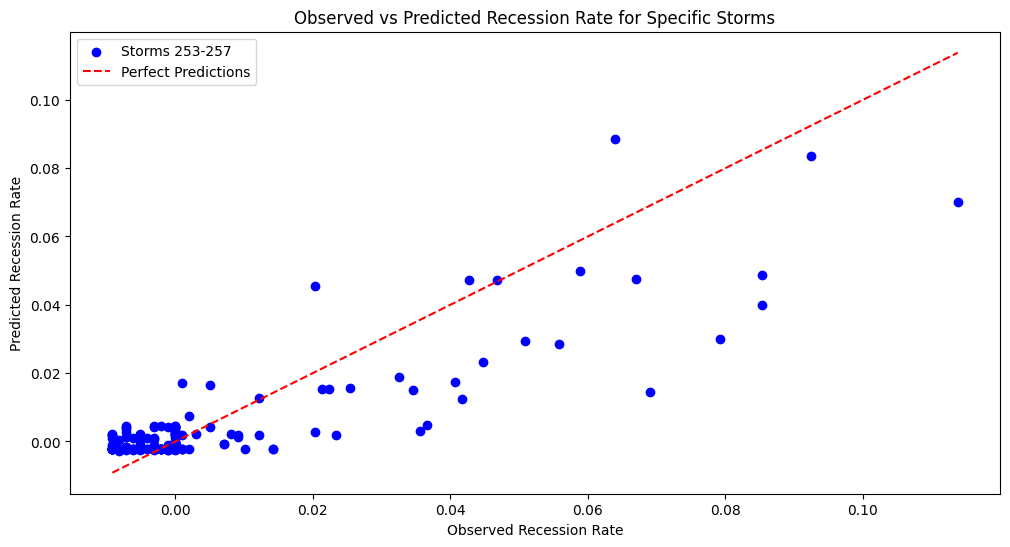

In [ ]:
import matplotlib.pyplot as plt

# Create a scatter plot of observed vs predicted values for each specific storm
plt.figure(figsize=(12, 6))
plt.title("Observed vs Predicted Recession Rate for Specific Storms")
plt.xlabel("Observed Recession Rate")
plt.ylabel("Predicted Recession Rate")

# Plot observed vs predicted values for each specific storm
plt.scatter(y_specific_storm, y_pred_specific_storm, label='Storms 253-257', color='blue', marker='o')

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_specific_storm), max(y_specific_storm)], [min(y_specific_storm), max(y_specific_storm)], linestyle='--', color='red', label='Perfect Predictions')

# Add a legend
plt.legend()

# Show the plot
plt.show()

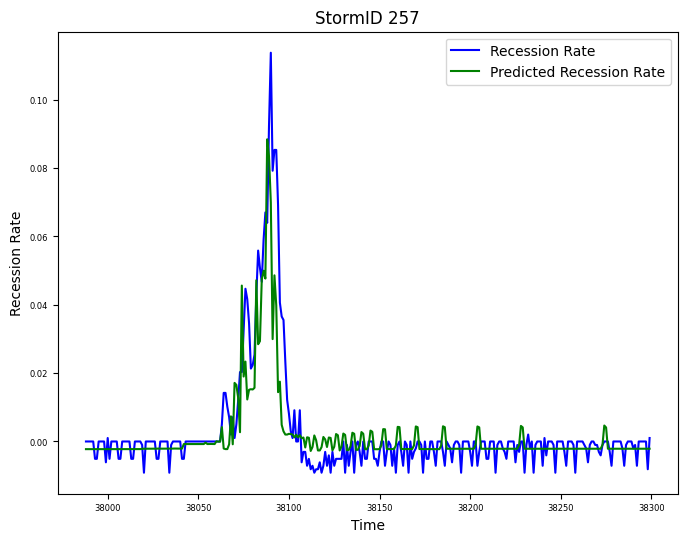

In [ ]:
# Create a plot for the specific storm
plt.figure(figsize=(8, 6))
plt.plot(specific_storm_data.index, specific_storm_data['Recession_Rate'], color='blue', label='Recession Rate')
plt.plot(specific_storm_data.index, y_pred_specific_storm, color='green', label='Predicted Recession Rate')
plt.xlabel('Time')
plt.ylabel('Recession Rate')
plt.title(f'StormID 257')
plt.legend()
plt.grid(False)

# Make x-ticks and y-ticks smaller
plt.tick_params(axis='both', which='both', labelsize=6)

# Show the plot
plt.show()

<Axes: >

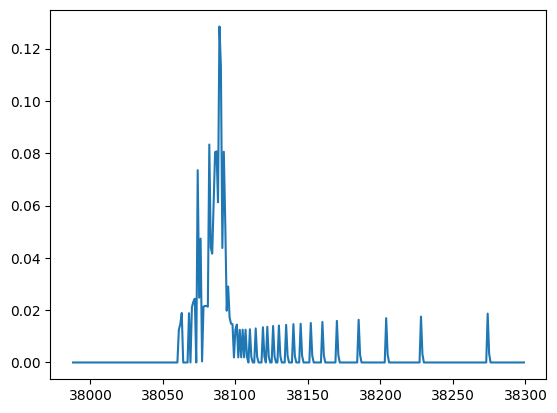

In [ ]:
specific_storm_data['Inflow'].plot()

#Model transfer variation in Inputs

In [ ]:
print(list(df))

['Datetime', 'Temp_Air', 'Temp_Moist', 'Soil_MC_10', 'Soil_MC_35', 'Soil_MC_65', 'Soil_MC_91', 'Inflow (mm/s)', 'Overflow(mm/s)', 'Precipitation (mm)', 'Water_Depth (mm)', 'Recession_Rate (mm/s)', 'SA (mm2)', 'Storm1', 'Storm2', 'StormID', 'Previous_Dry_Days', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'Peak_Inflow (mm/s)', 'Min_Inflow (mm/s)', 'Mean_Inflow (mm/s)', 'Min_RR (mm/s)', 'Mean_RR (mm/s)', 'Max_RR (mm/s)', 'Year', 'Month', 'Day', 'Season_Num', 'rain_indicator', 'hourly_rain', '30min_rain', '15min_rain']


In [ ]:
# Split the dataset based on unique storm events
unique_storm_events = df['StormID'].unique()
train_storm_events = unique_storm_events[:124]
test_storm_events = unique_storm_events[124:]

In [ ]:
test_storm_events

array([250, 253, 254, 256, 259, 260, 261, 262, 263, 269, 270, 271, 272,
       273, 274, 277, 284, 290, 291, 294, 295, 296, 298, 299, 302, 304,
       305, 308, 312, 320, 322, 325, 326])

In [ ]:
input_columns = ['Temp_Air', 'Temp_Moist', 'Soil_MC_10', 'Precipitation (mm)','Previous_Dry_Days', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'StormID']
#input_columns = ['Temp_Air', 'Precipitation (mm)','Previous_Dry_Days', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'StormID']
#input_columns = ['Precipitation (mm)','Previous_Dry_Days', 'StormID']

target_column = 'Recession_Rate (mm/s)'

In [ ]:
# Split the data into train and test sets
train_df = df[df['StormID'].isin(train_storm_events)]
test_df = df[df['StormID'].isin(test_storm_events)]

In [ ]:
# Define input features and target variable for the train and test sets
X_train = train_df[input_columns]
y_train = train_df[target_column]

X_test = test_df[input_columns]
y_test = test_df[target_column]

In [ ]:
X_train

,Temp_Air,Temp_Moist,Soil_MC_10,Precipitation (mm),Previous_Dry_Days,Accumulated_Rain (mm),Peak_Rain (mm),Mean_Rain (mm),StormID
0,9.81,5.1986,0.399205,0.0,0,0.4572,0.1016,0.005715,1
1,9.89,5.1946,0.396507,0.0,0,0.4572,0.1016,0.005715,1
2,9.91,5.1974,0.396507,0.0,0,0.4572,0.1016,0.005715,1
3,9.96,5.1998,0.395157,0.0,0,0.4572,0.1016,0.005715,1
4,9.98,5.2094,0.395157,0.0,0,0.4572,0.1016,0.005715,1
...,...,...,...,...,...,...,...,...,...
41333,16.41,15.8740,0.382000,0.0,0,1.5240,0.3556,0.007471,249
41334,16.43,15.8760,0.382000,0.0,0,1.5240,0.3556,0.007471,249
41335,16.50,15.8620,0.382000,0.0,0,1.5240,0.3556,0.007471,249
41336,16.53,15.8620,0.382000,0.0,0,1.5240,0.3556,0.007471,249


In [ ]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
# Create a RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_leaf=4, min_samples_split=2, random_state=42)  # You can adjust the number of estimators as needed
# Fit the model to the training data
model.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=4, random_state=42)

In [ ]:
# Make predictions on the train data
y_pred = model.predict(X_train_scaled)
# Evaluate the model
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 8.990124159995783e-05
R-squared: 0.48483024438833655


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import numpy as np

# Calculate Mean Squared Error
mse = mean_squared_error(y_train, y_pred)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_train, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Calculate R-squared Score
r2 = r2_score(y_train, y_pred)
print("R-squared (R2) Score:", r2)

# Calculate Explained Variance Score
evs = explained_variance_score(y_train, y_pred)
print("Explained Variance Score (EVS):", evs)

Mean Squared Error (MSE): 8.990124159995783e-05
Root Mean Squared Error (RMSE): 0.009481626527129078
Mean Absolute Error (MAE): 0.004111842159024027
R-squared (R2) Score: 0.48483024438833655
Explained Variance Score (EVS): 0.48483024646394135


In [ ]:
# Make predictions on the test data
y_pred = model.predict(X_test_scaled)
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 0.00016130149209107327
R-squared: 0.19285846682714636


In [ ]:
# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Calculate R-squared Score
r2 = r2_score(y_test, y_pred)
print("R-squared (R2) Score:", r2)

# Calculate Explained Variance Score
evs = explained_variance_score(y_test, y_pred)
print("Explained Variance Score (EVS):", evs)

Mean Squared Error (MSE): 0.00016130149209107327
Root Mean Squared Error (RMSE): 0.012700452436471438
Mean Absolute Error (MAE): 0.0052377845124810425
R-squared (R2) Score: 0.19285846682714636
Explained Variance Score (EVS): 0.1953457649558208


# Feature Importance

In [ ]:
print(list(df))

['Datetime', 'Temp_Air', 'Temp_Moist', 'Soil_MC_10', 'Soil_MC_35', 'Soil_MC_65', 'Soil_MC_91', 'Inflow (mm/s)', 'Overflow(mm/s)', 'Precipitation (mm)', 'Water_Depth (mm)', 'Recession_Rate (mm/s)', 'SA (mm2)', 'Storm1', 'Storm2', 'StormID', 'Previous_Dry_Days', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'Peak_Inflow (mm/s)', 'Min_Inflow (mm/s)', 'Mean_Inflow (mm/s)', 'Min_RR (mm/s)', 'Mean_RR (mm/s)', 'Max_RR (mm/s)', 'Year', 'Month', 'Day', 'Season_Num', 'rain_indicator', 'hourly_rain', '30min_rain', '15min_rain']


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import numpy as np

# Create a Random Forest Regressor model
rf_model = RandomForestRegressor()

# Fit the model on your training data
rf_model.fit(X_train, y_train)

# Perform permutation importance
results = permutation_importance(rf_model, X_train, y_train, n_repeats=10, random_state=42)

# Get sorted importances
sorted_importances_idx = results.importances_mean.argsort()

# Print the feature importances
print("Features sorted by their importance:")
print(np.array(input_columns)[sorted_importances_idx])

Features sorted by their importance:
['Previous_Dry_Days' 'Peak_Rain (mm)' 'Accumulated_Rain (mm)'
 'Overflow(mm/s)' 'StormID' 'Soil_MC_35' 'Soil_MC_10' 'Temp_Air'
 'Soil_MC_91' 'Temp_Moist' 'Mean_Rain (mm)' 'Soil_MC_65'
 'Precipitation (mm)' 'Inflow (mm/s)']


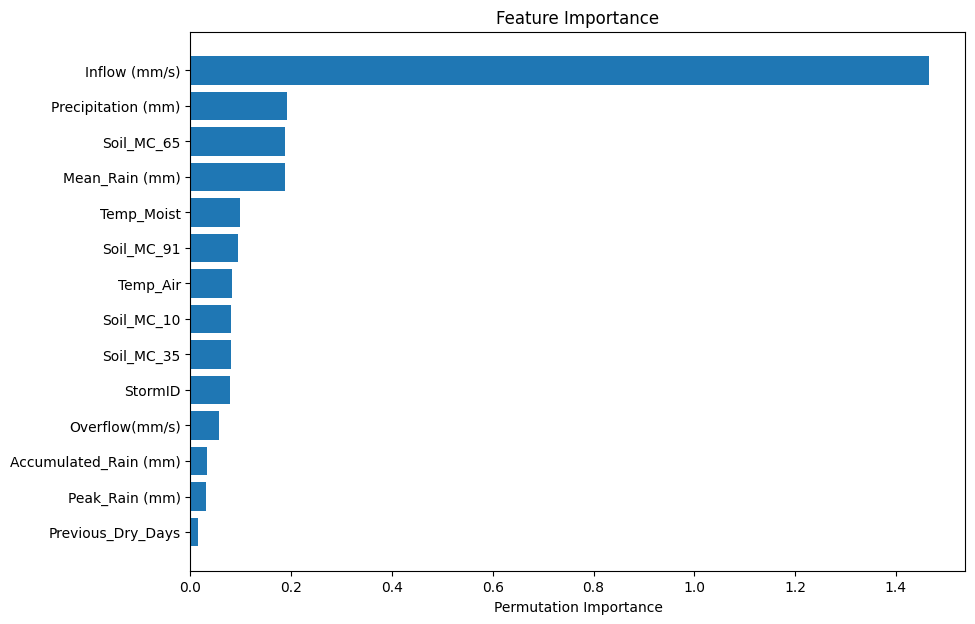

In [ ]:
import matplotlib.pyplot as plt

# Assuming `input_columns` is defined and matches the feature names in `X_train`
feature_names = np.array(input_columns)

# Sort the importances in descending order and get the indices
sorted_idx = results.importances_mean.argsort()[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 7))
plt.barh(range(len(sorted_idx)), results.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance")
plt.gca().invert_yaxis()  # Invert the y-axis to have the most important feature at the top
plt.show()

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

# Create a Random Forest Regressor model
rf_model = RandomForestRegressor()

# Create the RFE model and select 5 attributes
rfe = RFE(estimator=rf_model, n_features_to_select=5)  # Adjust the number of features as needed

# Fit RFE
rfe.fit(X_train, y_train)

# Print the ranking of features
feature_ranking = sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), input_columns))
print("Features sorted by their rank:")
print(feature_ranking)

Features sorted by their rank:
[(1, 'Inflow (mm/s)'), (1, 'Precipitation (mm)'), (1, 'Soil_MC_65'), (1, 'Temp_Air'), (1, 'Temp_Moist'), (2, 'Mean_Rain (mm)'), (3, 'Soil_MC_35'), (4, 'Soil_MC_91'), (5, 'Overflow(mm/s)'), (6, 'Soil_MC_10'), (7, 'Peak_Rain (mm)'), (8, 'Accumulated_Rain (mm)'), (9, 'StormID'), (10, 'Previous_Dry_Days')]


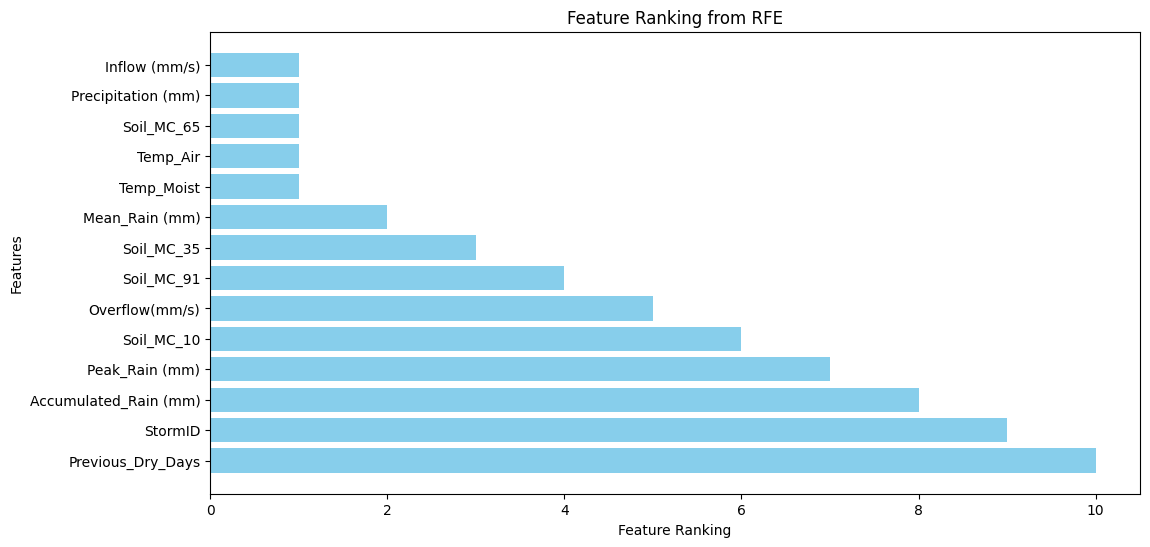

In [ ]:
import matplotlib.pyplot as plt

# Unzipping the rankings and feature names
rankings, features = zip(*feature_ranking)

# Creating a horizontal bar chart
plt.figure(figsize=(12, 6))
plt.barh(features, rankings, color='skyblue')
plt.xlabel('Feature Ranking')
plt.ylabel('Features')
plt.title('Feature Ranking from RFE')
plt.gca().invert_yaxis()  # Invert y-axis to show the best feature at the top
plt.show()

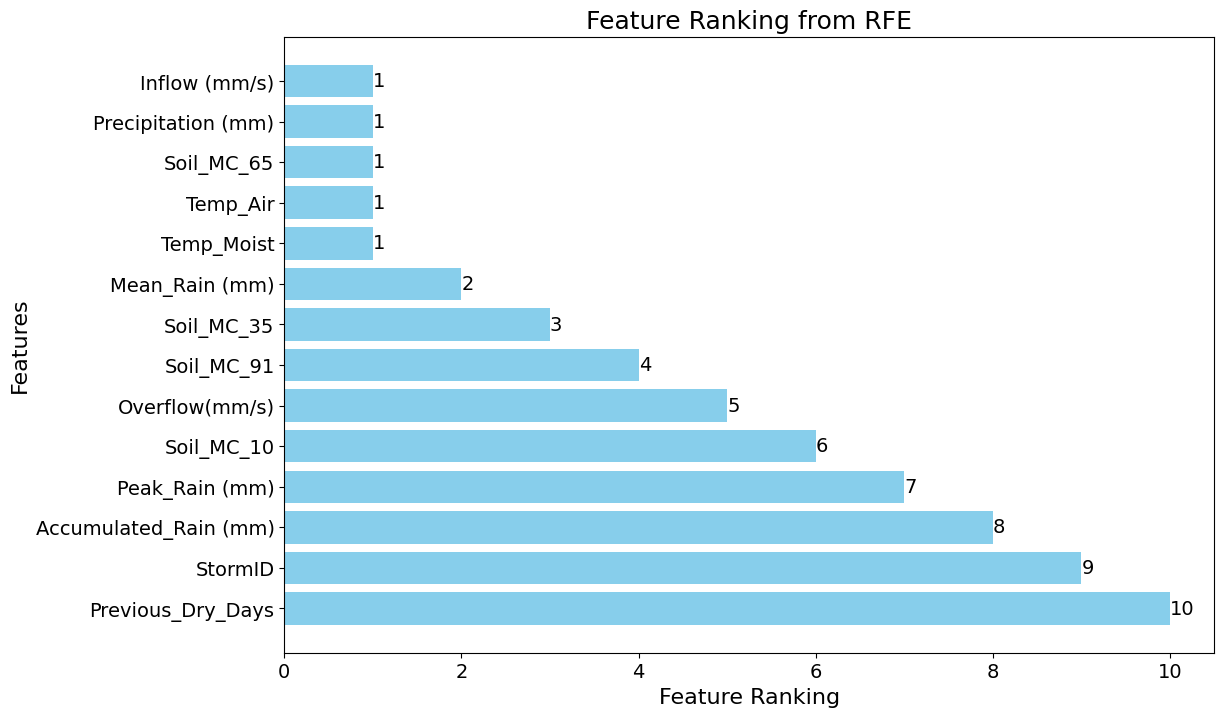

In [ ]:
import matplotlib.pyplot as plt

# Assuming feature_ranking is defined
# rankings, features = zip(*feature_ranking)

# Set global font size
plt.rcParams.update({'font.size': 14})  # Adjust as needed

# Creating a horizontal bar chart
plt.figure(figsize=(12, 8))  # Adjust size as needed
bars = plt.barh(features, rankings, color='skyblue')
plt.xlabel('Feature Ranking', fontsize=16)  # Adjust fontsize as needed
plt.ylabel('Features', fontsize=16)  # Adjust fontsize as needed
plt.title('Feature Ranking from RFE', fontsize=18)  # Adjust fontsize as needed
plt.gca().invert_yaxis()  # Invert y-axis to show the best feature at the top

# Adding the ranking values on the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2, f'{int(width)}', va='center', fontsize=14)  # Adjust fontsize as needed

plt.show()

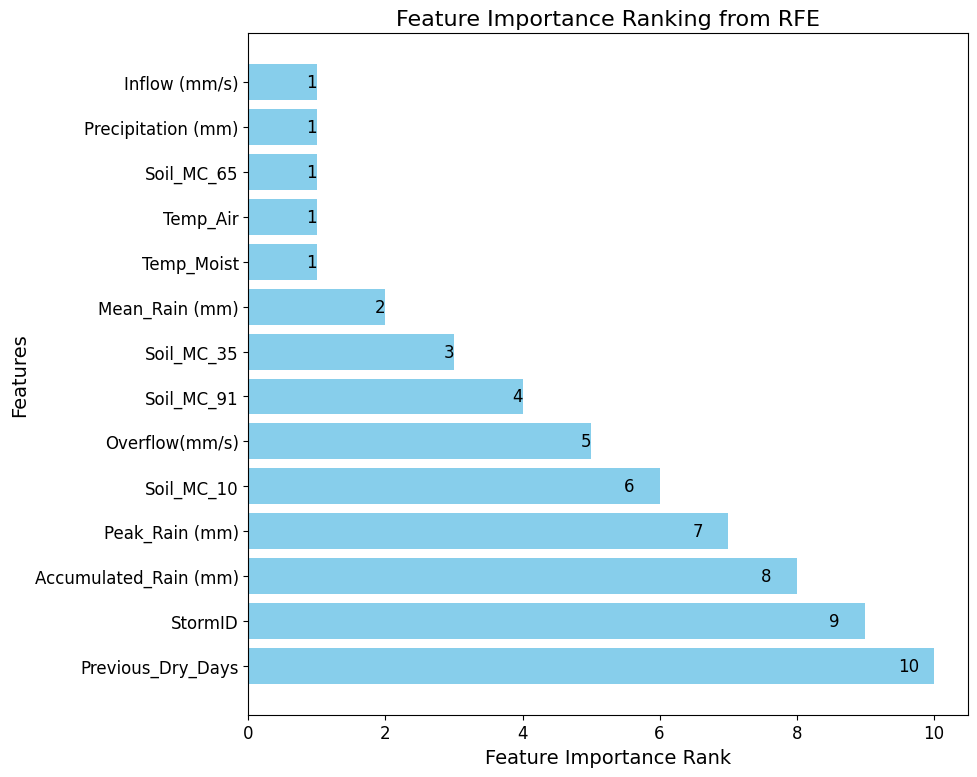

In [ ]:
# Unzipping the rankings and feature names
rankings, features = zip(*feature_ranking)

# Creating a horizontal bar chart for feature importances
plt.figure(figsize=(10, 8))
bars = plt.barh(features, rankings, color='skyblue')
plt.xlabel('Feature Importance Rank', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('Feature Importance Ranking from RFE', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top

# Adding the ranking values on the bars
for bar in bars:
    width = bar.get_width()
    label_x_pos = width if width < plt.xlim()[1] * 0.5 else width - (plt.xlim()[1] * 0.05)
    plt.text(label_x_pos, bar.get_y() + bar.get_height() / 2., f'{width}', va='center', ha='right' if width < plt.xlim()[1] * 0.5 else 'left', color='black', fontsize=12)

plt.tight_layout()
plt.show()

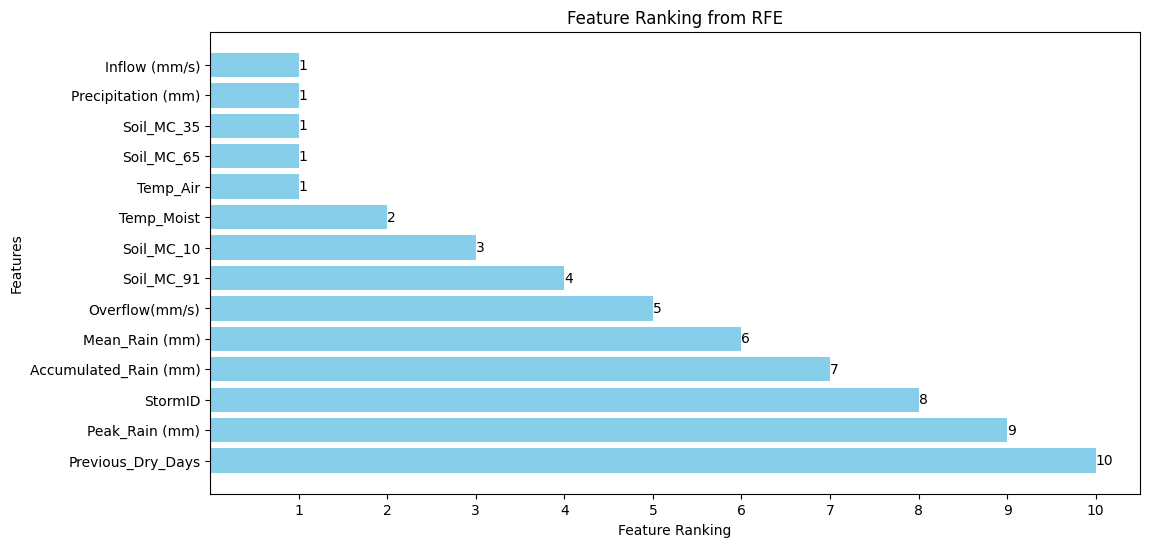

In [ ]:
# Correcting the code to display all x-tick values

plt.figure(figsize=(12, 6))
bars = plt.barh(features, rankings, color='skyblue')
plt.xlabel('Feature Ranking')
plt.ylabel('Features')
plt.title('Feature Ranking from RFE')
plt.gca().invert_yaxis()  # Invert y-axis to show the best feature at the top

# Adding the ranking values on the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width}', va='center')

# Converting rankings to numeric values and setting x-ticks
numeric_rankings = [int(r) for r in rankings]
plt.xticks(range(1, max(numeric_rankings) + 1))

plt.show()

In [ ]:
rankings

(1, 1, 1, 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10)

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.inspection import permutation_importance

# # Assuming you have a trained model named 'model' and data 'X_test', 'y_test'

# # Compute Permutation Feature Importance
# perm_importance = permutation_importance(model, X_test, y_test, n_repeats=30)

# # Sort the features by importance
# sorted_idx = perm_importance.importances_mean.argsort()

# # Plotting
# plt.figure(figsize=(12, 6))
# plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
# plt.yticks(range(len(sorted_idx)), np.array(input_columns)[sorted_idx])
# plt.xlabel("Permutation Importance")
# plt.title("Permutation Feature Importance")
# plt.show()

In [ ]:
!pip install scikit-learn

In [ ]:
pip install --upgrade scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 33.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
print(list(X_train))

['Temp_Air', 'Temp_Moist', 'Soil_MC_10', 'Soil_MC_35', 'Soil_MC_65', 'Soil_MC_91', 'Inflow (mm/s)', 'Overflow(mm/s)', 'Precipitation (mm)', 'Previous_Dry_Days', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'StormID']


In [ ]:
from sklearn.inspection import PartialDependenceDisplay

# Initialize and fit the Gradient Boosting model
my_model = RandomForestRegressor()
my_model.fit(X_train, y_train)

TypeError: validate_params() got an unexpected keyword argument 'prefer_skip_nested_validation'

NameError: name 'PartialDependenceDisplay' is not defined

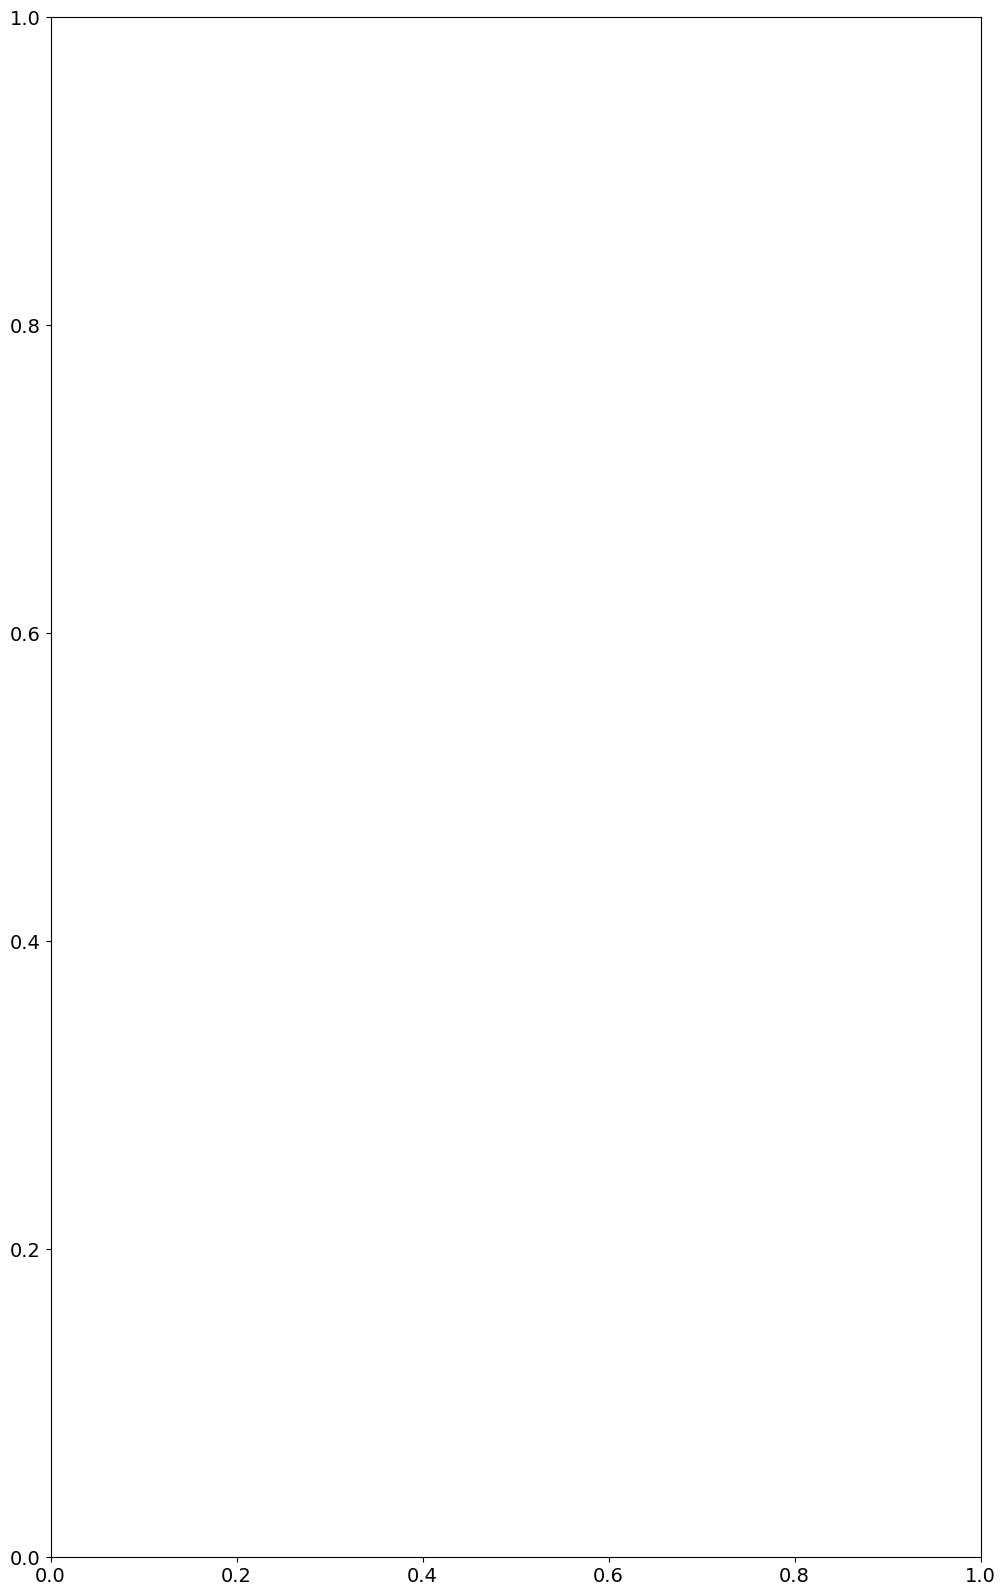

In [ ]:
# # Create Partial Dependence Plots
# fig, ax = plt.subplots(figsize=(12, 4))
# PartialDependenceDisplay.from_estimator(my_model, X_train, [1:8],
#                                         feature_names=['Temp_Air', 'Temp_Moist', 'Soil_MC_10', 'Soil_MC_35', 'Soil_MC_65', 'Soil_MC_91', 'Inflow (mm/s)', 'Overflow(mm/s)', 'Precipitation (mm)', 'Previous_Dry_Days', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)'],
#                                         grid_resolution=10, ax=ax)
# plt.show()

feature_indices = list(range(1, 12))  # This will select features 1 through 7

fig, ax = plt.subplots(figsize=(12, 20))
PartialDependenceDisplay.from_estimator(
    my_model, X_train, feature_indices,
    feature_names=['Temp_Air', 'Temp_Moist', 'Soil_MC_10', 'Soil_MC_35', 'Soil_MC_65', 'Soil_MC_91', 'Inflow (mm/s)', 'Overflow(mm/s)', 'Precipitation (mm)', 'Previous_Dry_Days', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)'],
    grid_resolution=10, ax=ax
)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# Increase font sizes
plt.rcParams['font.size'] = 12  # Adjust as needed
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

feature_indices = list(range(1, 12))  # This will select features 1 through 11
feature_names = ['Temp_Air', 'Temp_Moist', 'Soil_MC_10', 'Soil_MC_35', 'Soil_MC_65', 'Soil_MC_91', 'Inflow (mm/s)', 'Overflow(mm/s)', 'Precipitation (mm)', 'Previous_Dry_Days', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)']

fig, ax = plt.subplots(figsize=(12, 20))

# Customize the plot with a style context
with plt.style.context('ggplot'):  # You can change 'ggplot' to 'seaborn' or another style
    display = PartialDependenceDisplay.from_estimator(
        my_model, X_train, feature_indices,
        feature_names=feature_names,
        grid_resolution=10, ax=ax, n_jobs=3
    )
    display.figure_.suptitle('Partial Dependence of Features', fontweight='bold')
    display.figure_.subplots_adjust(top=0.9)  # Adjust the title position
    ax.set_ylabel('Partial Dependence (dPD)')

    # Set y-axis limits
    #ax.set_ylim(-0.003, 0.01)

    plt.show()


TypeError: validate_params() got an unexpected keyword argument 'prefer_skip_nested_validation'

In [ ]:
# Assuming model is your trained model and X is your feature DataFrame
features = input_columns  # You can select specific features as well

# Create the partial dependence plots
fig, ax = plt.subplots(figsize=(15, 10))
plot_partial_dependence(model, X, features, ax=ax, n_jobs=3, grid_resolution=20)

# Customize the plots
ax.set_title('Partial Dependence Plots')
plt.tight_layout()
plt.show()